In [1]:
import pandas as pd
import numpy as np
import glob
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import plot_hyb
import predict_Beta_I
import seir_discrete
import choice_start_day
import switch
%load_ext autoreload
%autoreload 2

In [2]:
df_orig = pd.read_csv('chel_03_seeds_parameters.csv')
# Чтобы в каждом наборе параметров было минимум 2 файла
# keep = False, чтобы и первые, и последние строки считались за дубликат
dfp = df_orig[df_orig.duplicated(['alpha', 'lambda'], keep=False)]

X = dfp[['file']]
y = dfp[['alpha', 'lambda']]

X_train, X_test = train_test_split(X, test_size=0.2, 
                                   random_state=42, stratify=y)
y = y.loc[X_train.index]
X_train, X_val = train_test_split(X_train, test_size=0.2, 
                                  random_state=42, stratify=y)

X_train_all = pd.concat([X_train, X_val])

X_train.shape, X_test.shape, X_val.shape

((1042, 1), (326, 1), (261, 1))

In [5]:
# пересчитываем бету; раньше могла быть проблема с индексами

for idx, i in enumerate(X_train_all['file'].values.flatten()):
    df = pd.read_csv(i)
    df.beta_H1N1 = -df.S_H1N1.diff()[1:].reset_index(drop=True
                                        ) / (df.S_H1N1[:-1]*df.I_H1N1[:-1])
    S_eq_0 = df[df.S_H1N1==0].index
    if S_eq_0.shape[0]>1:
        df.loc[S_eq_0[0]-1, 'beta_H1N1'] = 0
        
    #df.to_csv(i, index=False)
    
for idx, i in enumerate(X_test['file'].values.flatten()):
    df = pd.read_csv(i)
    df.beta_H1N1 = -df.S_H1N1.diff()[1:].reset_index(drop=True
                                        ) / (df.S_H1N1[:-1]*df.I_H1N1[:-1])
    S_eq_0 = df[df.S_H1N1==0].index
    if S_eq_0.shape[0]>1:
        df.loc[S_eq_0[0]-1, 'beta_H1N1'] = 0
        
    #df.to_csv(i, index=False)

In [3]:
df = pd.read_csv(i)
df

NameError: name 'i' is not defined

In [7]:
df[df.S_H1N1==0].index

Index([ 44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
       ...
       240, 241, 242, 243, 244, 245, 246, 247, 248, 249],
      dtype='int64', length=206)

In [8]:
df.iloc[40:45]

S_H1N1  E_H1N1  I_H1N1    R_H1N1  beta_H1N1
40  246504.0     0.0    13.0  548819.0       -0.0
41  246504.0     0.0     6.0  548826.0       -0.0
42  246504.0     0.0     6.0  548826.0       -0.0
43  246504.0     0.0     5.0  548827.0        0.0
44       0.0     0.0     0.0       0.0        NaN

In [ ]:
S_eq_0 = df[df.S_H1N1==0].index
if S_eq_0.shape[0]>1:
    df.loc[S_eq_0[0]-1, 'beta_H1N1'] = 0

In [3]:
X_train_all.sort_values('file')
X_train_all[['alpha', 'lmbd']] = X_train_all['file'].apply(lambda x: [x.split('\\')[-1].split('_')[i]
                                                                      for i in [1,3]] 
                                                          ).to_list()
X_train_all.sort_values('file')

file alpha lmbd
173   chelyabinsk_0.3_sampled\alpha_0.15_lmbd_0.3_se...  0.15  0.3
1044  chelyabinsk_0.3_sampled\alpha_0.15_lmbd_0.3_se...  0.15  0.3
524   chelyabinsk_0.3_sampled\alpha_0.15_lmbd_0.3_se...  0.15  0.3
953   chelyabinsk_0.3_sampled\alpha_0.15_lmbd_0.3_se...  0.15  0.3
736   chelyabinsk_0.3_sampled\alpha_0.15_lmbd_0.3_se...  0.15  0.3
...                                                 ...   ...  ...
441   chelyabinsk_0.3_sampled\alpha_1.00_lmbd_0.1_se...  1.00  0.1
628   chelyabinsk_0.3_sampled\alpha_1.00_lmbd_0.1_se...  1.00  0.1
917   chelyabinsk_0.3_sampled\alpha_1.00_lmbd_0.1_se...  1.00  0.1
228   chelyabinsk_0.3_sampled\alpha_1.00_lmbd_0.1_se...  1.00  0.1
992   chelyabinsk_0.3_sampled\alpha_1.00_lmbd_0.1_se...  1.00  0.1

[1303 rows x 3 columns]

In [4]:
X_train_all.groupby(['alpha', 'lmbd']).count()

file
alpha lmbd      
0.15  0.3      7
      0.4      7
      0.5      8
      0.6      8
      0.7      8
...          ...
0.95  0.7      8
      0.8      8
      0.9      8
      1.0      8
1.00  0.1      8

[167 rows x 1 columns]

In [5]:
one_fi = X_train_all[X_train_all.file.str.contains('alpha_0.70_lmbd_0.4')]
one_fi

file alpha lmbd
77    chelyabinsk_0.3_sampled\alpha_0.70_lmbd_0.4_se...  0.70  0.4
1522  chelyabinsk_0.3_sampled\alpha_0.70_lmbd_0.4_se...  0.70  0.4
241   chelyabinsk_0.3_sampled\alpha_0.70_lmbd_0.4_se...  0.70  0.4
479   chelyabinsk_0.3_sampled\alpha_0.70_lmbd_0.4_se...  0.70  0.4
1125  chelyabinsk_0.3_sampled\alpha_0.70_lmbd_0.4_se...  0.70  0.4
1370  chelyabinsk_0.3_sampled\alpha_0.70_lmbd_0.4_se...  0.70  0.4
1572  chelyabinsk_0.3_sampled\alpha_0.70_lmbd_0.4_se...  0.70  0.4
725   chelyabinsk_0.3_sampled\alpha_0.70_lmbd_0.4_se...  0.70  0.4

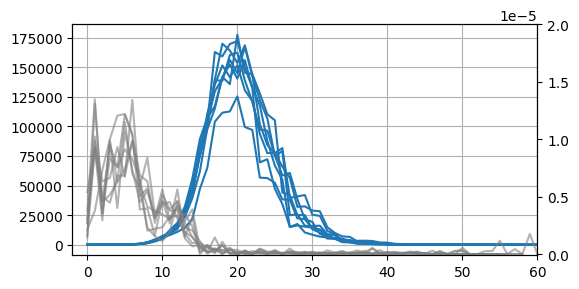

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax_b = ax.twinx()
beta_8 = pd.DataFrame()

for idx, i in enumerate(one_fi['file'].values.flatten()):
    df = pd.read_csv(i)
    ax.plot(df.I_H1N1, color='tab:blue')
    beta_v = df.beta_H1N1
    ax_b.plot(beta_v, color='gray', alpha=0.6)
    beta_8[idx] = beta_v
    
plt.xlim(-2, 60)
ax_b.set_ylim(-1e-7, 2e-5)
ax.grid()

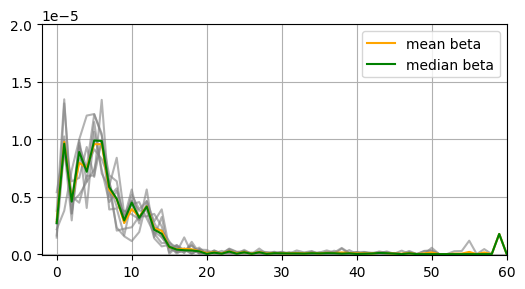

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

ax.plot(beta_8, color='gray', alpha=0.6)
ax.plot(beta_8.mean(1), color='orange', label='mean beta')
ax.plot(beta_8.median(1), color='green', label='median beta')

plt.xlim(-2, 60)
plt.ylim(-1e-7,2e-5)
ax.legend()
ax.grid()

### пучок абм и бет

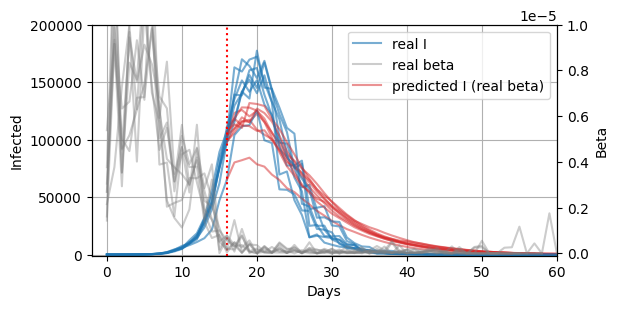

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax_b = ax.twinx()

sigma = 1/2
gamma = 1/6

for i in one_fi['file'].values.flatten():
    df = pd.read_csv(i)
    beta_v = df.beta_H1N1#.replace([np.inf, -np.inf,np.nan], 0)
    l1 = ax.plot(df.I_H1N1, color='tab:blue', alpha=0.6,
                label='real I')
    l2 = ax_b.plot(beta_v, color='gray', alpha=0.4,
                  label='real beta')

    switch_day=16
    seed_df = df.iloc[:,:5].copy()
    seed_df.columns = ['S','E','I','R','Beta']
    real_peakt = seed_df.I.argmax()
    real_peakh = seed_df.I.max()

    y0 = seed_df.iloc[switch_day,:4].values
    ts = np.arange(seed_df.shape[0]-switch_day)

    b  = beta_v[switch_day:].values
    S,E,I,R = seir_discrete.seir_model(y0, ts, b, 
                                       sigma, gamma, stype='d', 
                                       beta_t=True).T

    l3 = ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
                    alpha=0.5, label='predicted I (real beta)')
    
ax.axvline(switch_day, ls=':', color='red')
ax.set_xlim(-2, 60)
ax.set_ylim(-1e3,2e5)
ax_b.set_ylim(-1e-7, 1e-5)

lns = l1+l2+l3
labs = [l.get_label() for l in lns]
leg = ax.legend(lns, labs)

ax.set_ylabel('Infected')
ax_b.set_ylabel('Beta')
ax.set_xlabel('Days')
ax.grid()
plt.savefig(f'results/same_params_real_beta.pdf', 
            format='pdf', bbox_inches='tight')

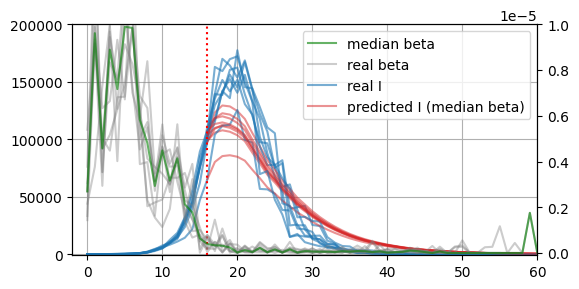

In [6]:
# подаем МЕДИАНУ бет; 16 день

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax_b = ax.twinx()

sigma = 1/2
gamma = 1/6



for idx, i in enumerate(one_fi['file'].values.flatten()):
    df = pd.read_csv(i)
    
    l2 = ax_b.plot(df.beta_H1N1, color='gray', alpha=0.4,
                  label='real beta')
    l3 = ax.plot(df.I_H1N1, color='tab:blue', alpha=0.6, 
                 label='real I')

    switch_day=16
    
    seed_df = df.iloc[:,:5].copy()
    seed_df.columns = ['S','E','I','R','Beta']
    real_peakt = seed_df.I.argmax()
    real_peakh = seed_df.I.max()

    y0 = seed_df.iloc[switch_day,:4].values
    ts = np.arange(seed_df.shape[0]-switch_day)

    b = beta_8.median(1)[switch_day:].values
    S,E,I,R = seir_discrete.seir_model(y0, ts, b, 
                                       sigma, gamma, stype='d', 
                                       beta_t=True).T
    

    l4 = ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
                    alpha=0.5, label='predicted I (median beta)')
    
l1 = ax_b.plot(beta_8.median(1), color='green', alpha=0.6,
              label='median beta')   

ax.axvline(switch_day, ls=':', color='red')
lns = l1+l2+l3+l4
labs = [l.get_label() for l in lns]
leg = ax.legend(lns, labs)
leg.set_zorder(99999)

ax.set_xlim(-2, 60)
ax.set_ylim(-1e3,2e5)
ax_b.set_ylim(-1e-7, 1e-5)
ax.grid()

(-2.0, 60.0)

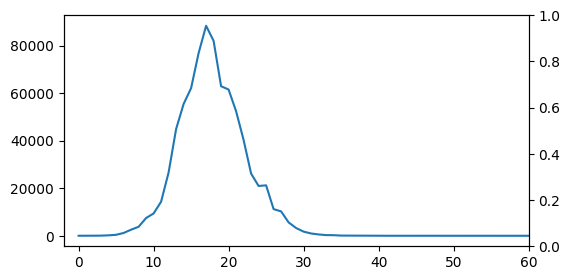

In [40]:
i = X_train_all['file'].values.flatten()[600]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax_b = ax.twinx()

sigma = 1/2
gamma = 1/6

df = pd.read_csv(i)

ax.plot(df.I_H1N1, color='tab:blue', alpha=1, 
             label='real I')
ax.set_xlim(-2, 60)

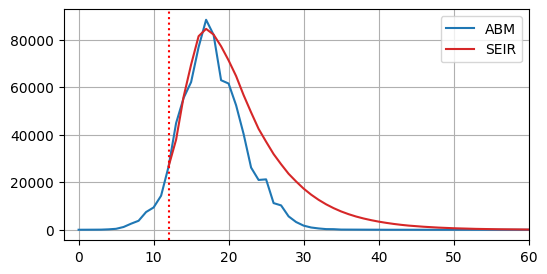

In [9]:
i = one_fi['file'].values.flatten()[-1]
i = X_train_all['file'].values.flatten()[600]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))


sigma = 1/2
gamma = 1/6

df = pd.read_csv(i)

l3 = ax.plot(df.I_H1N1, color='tab:blue', alpha=1, 
             label='ABM')

seed_df = df.iloc[:,:5].copy()
seed_df.columns = ['S','E','I','R','Beta']
real_peakt = seed_df.I.argmax()
real_peakh = seed_df.I.max()

switch_day=real_peakt-5

y0 = seed_df.iloc[switch_day,:4].values
ts = np.arange(seed_df.shape[0]-switch_day)

b = beta_8.median(1)[switch_day:].values
S,E,I,R = seir_discrete.seir_model(y0, ts, b, 
                                   sigma, gamma, stype='d', 
                                   beta_t=True).T


l4 = ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
                alpha=1, label='SEIR')

ax.axvline(switch_day, ls=':', color='red')
lns =l3+l4
labs = [l.get_label() for l in lns]
leg = ax.legend(lns, labs)
leg.set_zorder(99999)

ax.set_xlim(-2, 60)
ax.grid()

In [10]:
I[:50]

array([26628.        , 37913.5       , 55918.73761419, 69469.48409482,
       81434.14257738, 84516.54789029, 82122.81130774, 77186.15540642,
       71263.14951867, 64667.5767177 , 56664.04836937, 49390.69330822,
       42456.36303597, 37059.03069614, 31853.60211056, 27568.58178916,
       23556.42720577, 20326.0751928 , 17331.99611604, 14791.98655848,
       12604.08904173, 10717.55327115,  9105.30907314,  7717.30633538,
        6561.11653389,  5574.06653205,  4747.87655129,  4047.54360234,
        3435.25960398,  2920.07225552,  2466.96955348,  2081.86618873,
        1758.91381229,  1497.175969  ,  1276.2223974 ,  1083.28735384,
         912.6238062 ,   771.84402795,   648.86545135,   543.55225682,
         454.3757377 ,   379.35420992,   316.48238919,   263.91226478,
         220.01535755,   183.39036641,   152.8474229 ,   127.38391119,
         106.15878872,   108.68647664])

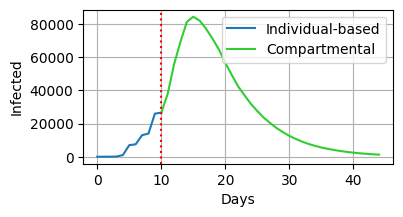

In [11]:
plt.subplots(1, 1, figsize=(4, 2))

plt.plot(np.arange(11),
         [10,10,38,108,1016,7000,7500,13000,14000,26000,26628],
        label='Individual-based', lw=1.5)
ii = I[:35]
plt.plot(np.arange(10,ii.shape[0]+10), ii, label='Compartmental', 
         color='limegreen', lw=1.5)
plt.axvline(10, ls=':', color='red', lw=1.5)

plt.ylabel('Infected')
plt.xlabel('Days')
plt.grid()
plt.legend()

plt.savefig(f'example.png', format='png', bbox_inches='tight', dpi=900)

In [43]:
seed_df.I[:13]

0        10.0
1        10.0
2        38.0
3        59.0
4       185.0
5       408.0
6      1176.0
7      2563.0
8      3790.0
9      7469.0
10     9387.0
11    14332.0
12    26628.0
Name: I, dtype: float64

In [ ]:
plt.plot()

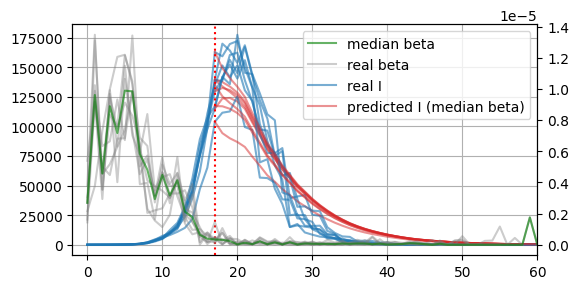

In [128]:
# подаем МЕДИАНУ бет; 17 день

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax_b = ax.twinx()

sigma = 1/2
gamma = 1/6

for idx, i in enumerate(one_fi['file'].values.flatten()):
    df = pd.read_csv(i)
    
    l2 = ax_b.plot(df.beta_H1N1, color='gray', alpha=0.4,
                  label='real beta')
    l3 = ax.plot(df.I_H1N1, color='tab:blue', alpha=0.6, 
                 label='real I')
    switch_day=17
    
    seed_df = df.iloc[:,:5].copy()
    seed_df.columns = ['S','E','I','R','Beta']
    real_peakt = seed_df.I.argmax()
    real_peakh = seed_df.I.max()

    y0 = seed_df.iloc[switch_day,:4].values
    ts = np.arange(seed_df.shape[0]-switch_day)

    b = beta_8.median(1)[switch_day:].values
    S,E,I,R = seir_discrete.seir_model(y0, ts, b, 
                                       sigma, gamma, stype='d', 
                                       beta_t=True).T
    

    l4 = ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
                    alpha=0.5, label='predicted I (median beta)')
    
l1 = ax_b.plot(beta_8.median(1), color='green', alpha=0.6,
              label='median beta')   

ax.axvline(switch_day, ls=':', color='red')
lns = l1+l2+l3+l4
labs = [l.get_label() for l in lns]
leg = ax.legend(lns, labs)

plt.xlim(-2, 60)
ax.grid()

In [109]:
one_fi = X_train_all[X_train_all.file.str.contains('alpha_0.80_lmbd_0.3')]
one_fi

file alpha lmbd
828   chelyabinsk_0.3_sampled\alpha_0.80_lmbd_0.3_se...  0.80  0.3
483   chelyabinsk_0.3_sampled\alpha_0.80_lmbd_0.3_se...  0.80  0.3
677   chelyabinsk_0.3_sampled\alpha_0.80_lmbd_0.3_se...  0.80  0.3
7     chelyabinsk_0.3_sampled\alpha_0.80_lmbd_0.3_se...  0.80  0.3
174   chelyabinsk_0.3_sampled\alpha_0.80_lmbd_0.3_se...  0.80  0.3
878   chelyabinsk_0.3_sampled\alpha_0.80_lmbd_0.3_se...  0.80  0.3
1084  chelyabinsk_0.3_sampled\alpha_0.80_lmbd_0.3_se...  0.80  0.3
270   chelyabinsk_0.3_sampled\alpha_0.80_lmbd_0.3_se...  0.80  0.3

### another params

In [110]:
beta_8 = pd.DataFrame()

for idx, i in enumerate(one_fi['file'].values.flatten()):
    beta_8[idx] = df.beta_H1N1

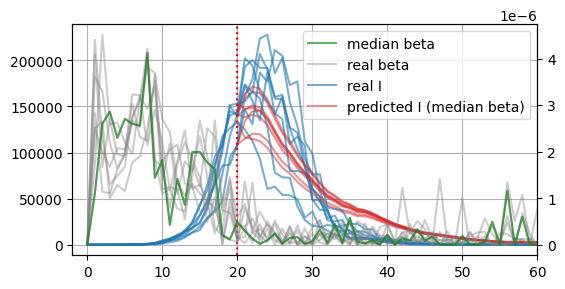

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax_b = ax.twinx()

sigma = 1/2
gamma = 1/6

for idx, i in enumerate(one_fi['file'].values.flatten()):
    df = pd.read_csv(i)
    
    l2 = ax_b.plot(df.beta_H1N1, color='gray', alpha=0.4,
                  label='real beta')
    l3 = ax.plot(df.I_H1N1, color='tab:blue', alpha=0.6, 
                 label='real I')

    switch_day=20
    
    seed_df = df.iloc[:,:5].copy()
    seed_df.columns = ['S','E','I','R','Beta']

    y0 = seed_df.iloc[switch_day,:4].values
    ts = np.arange(seed_df.shape[0]-switch_day)

    b = beta_8.median(1)[switch_day:].values
    S,E,I,R = seir_discrete.seir_model(y0, ts, b, 
                                       sigma, gamma, stype='d', 
                                       beta_t=True).T
    
    l4 = ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
                    alpha=0.5, label='predicted I (median beta)')
    
    
l1 = ax_b.plot(beta_8.median(1), color='green', alpha=0.6,
              label='median beta')   

ax.axvline(switch_day, ls=':', color='red')
lns = l1+l2+l3+l4
labs = [l.get_label() for l in lns]
leg = ax.legend(lns, labs)

plt.xlim(-2, 60)
ax.grid()

## all train trajectories

Text(0, 0.5, 'Beta')

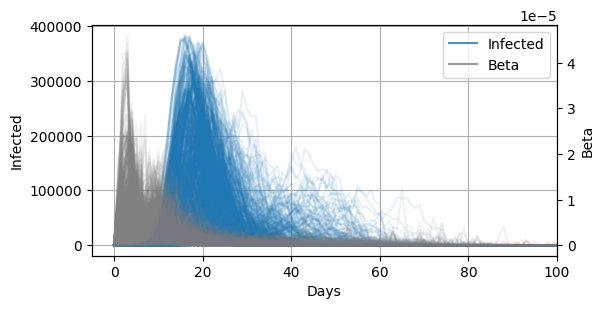

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax_b = ax.twinx()
bad = []

for i in [*X_train.values.flatten(), 
          *X_val.values.flatten()]:
    df = pd.read_csv(i)
    if df['I_H1N1'].max() >= 10000:
        ax.plot(df.I_H1N1, color='tab:blue', alpha=0.1)
        ax_b.plot(df.beta_H1N1, color='gray', alpha=0.1)
    else:
        bad.append(i)
        #print(i)
        
l1 = ax.plot(df.I_H1N1, color='tab:blue', alpha=0.1, label='Infected')
l2 = ax_b.plot(df.beta_H1N1, color='gray', alpha=0.1, label='Beta')        


ax.set_xlim(-5, 100)
ax.grid()

lns = l1+l2
labs = [l.get_label() for l in lns]

leg = ax.legend(lns, labs)
for lh in leg.legend_handles: 
    lh.set_alpha(0.8)
leg.set_zorder(20)

ax.set_xlabel('Days')
ax.set_ylabel('Infected')
ax_b.set_ylabel('Beta')


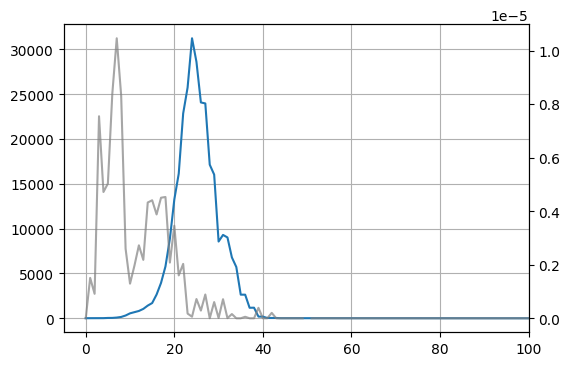

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax_b = ax.twinx()

one_seed = X_train.values.flatten()[300]
df = pd.read_csv(one_seed)

ax.plot(df.I_H1N1, color='tab:blue', alpha=1)
ax_b.plot(df.beta_H1N1, color='gray', alpha=.7)

ax.set_xlim(-5, 100)
ax.grid()

## constant beta as input

In [15]:
seed_df.iloc[0,:4].sum()

np.float64(795336.0)

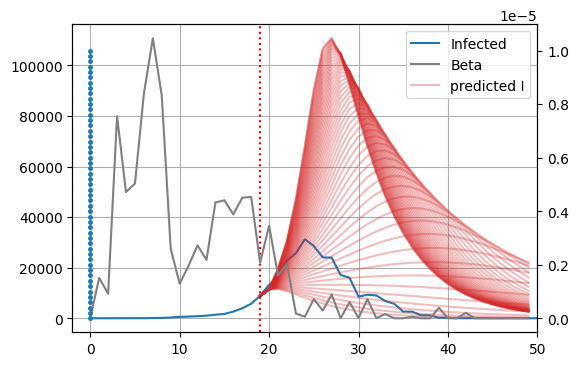

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax_b = ax.twinx()

df = pd.read_csv(one_seed)

if df['I_H1N1'].max() >= 10000:
    l1 = ax.plot(df.I_H1N1, color='tab:blue', alpha=1, label='Infected')
    
    seed_df = df.iloc[:,:5].copy()
    seed_df.columns = ['S','E','I','R','Beta']
    end_df  = seed_df[(seed_df.E==0)&(seed_df.I==0)]
    if end_df.shape[0]:
        seed_df = seed_df.iloc[:end_df.index[0]].copy()
        
    real_peakt = seed_df.I.argmax()
    real_peakh = seed_df.I.max()
    
    switch_day = choice_start_day.cpoint_fraq_people(seed_df, fraq=0.01)
    l2 = ax_b.plot(seed_df.Beta, color='gray', alpha=1, label='Beta')
    #switch_day=25
    y0 = seed_df.iloc[switch_day,:4].values
    ts = np.arange(seed_df.shape[0]-switch_day)
    
    sigma = 1/2
    gamma = 1/6

    res_dict = dict()
    
    for b in np.arange(0.0, 1e-5, 2e-7):
        ax_b.plot(0, b, marker='.', color='tab:blue', markersize=5)
        #ax_beta.plot(b, ls='--', color='tab:green')
        S,E,I,R = seir_discrete.seir_model(y0, ts, b, 
                                           sigma, gamma, stype='d', 
                                           beta_t=False).T
        ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
                alpha=0.3, label=label)

        predicted_peakt = I.argmax()+switch_day
        predicted_peakh = I.max()

        pt_err = abs(real_peakt - predicted_peakt)
        ph_err = abs(real_peakh - predicted_peakh)
        #traj_err = rmse(df_b.I_H1N1.iloc[switch_day:], I) 
        #res_dict[b] = [pt_err,ph_err,traj_err]
    
l3 = ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
                alpha=0.3, label='predicted I')

lns = l1+l2+l3
labs = [l.get_label() for l in lns]

leg = ax.legend(lns, labs)

ax.axvline(switch_day, ls=':', color='red')    
ax.set_xlim(-2, 50)
ax.grid()    

In [90]:
import random

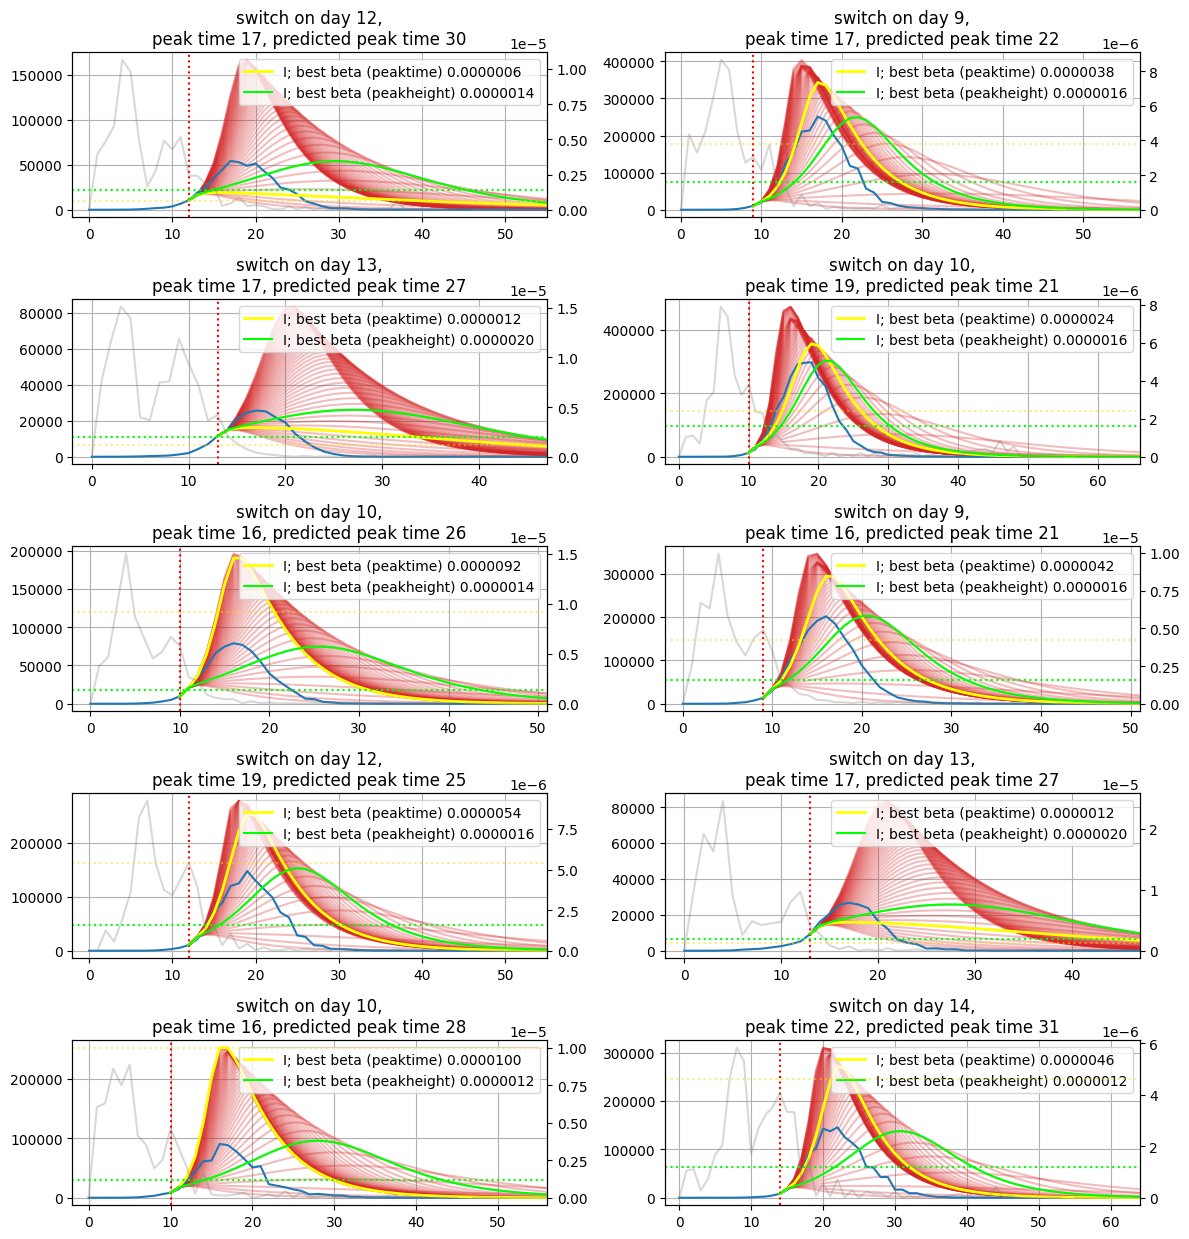

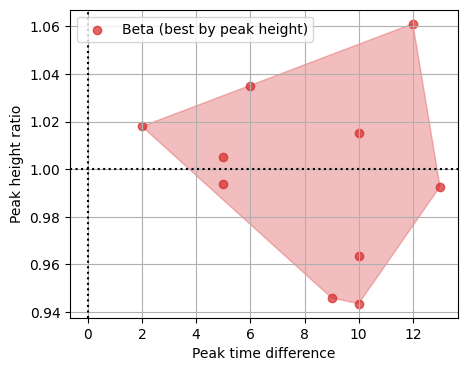

In [100]:
random.seed(42)

files =  [*X_train.values.flatten(), *X_val.values.flatten()]
files = np.array( random.sample(list(files), 10) )
switch.constant_betas_all(start_day='fraq_people', sigma=1/2, gamma=1/6,
                          files = files, plot=True, by_peak_='height')

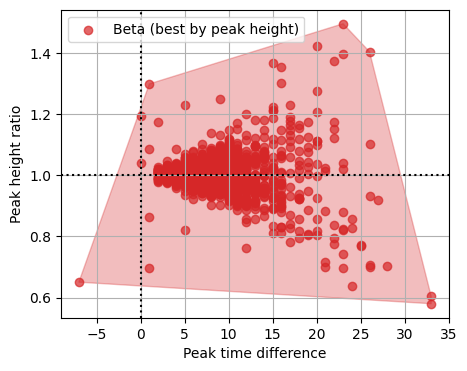

In [87]:
files =  np.array([*X_train.values.flatten(), *X_val.values.flatten()])
switch.constant_betas_all(start_day='fraq_people', sigma=1/2, gamma=1/6,
                          files = files, plot=False, by_peak_='height')

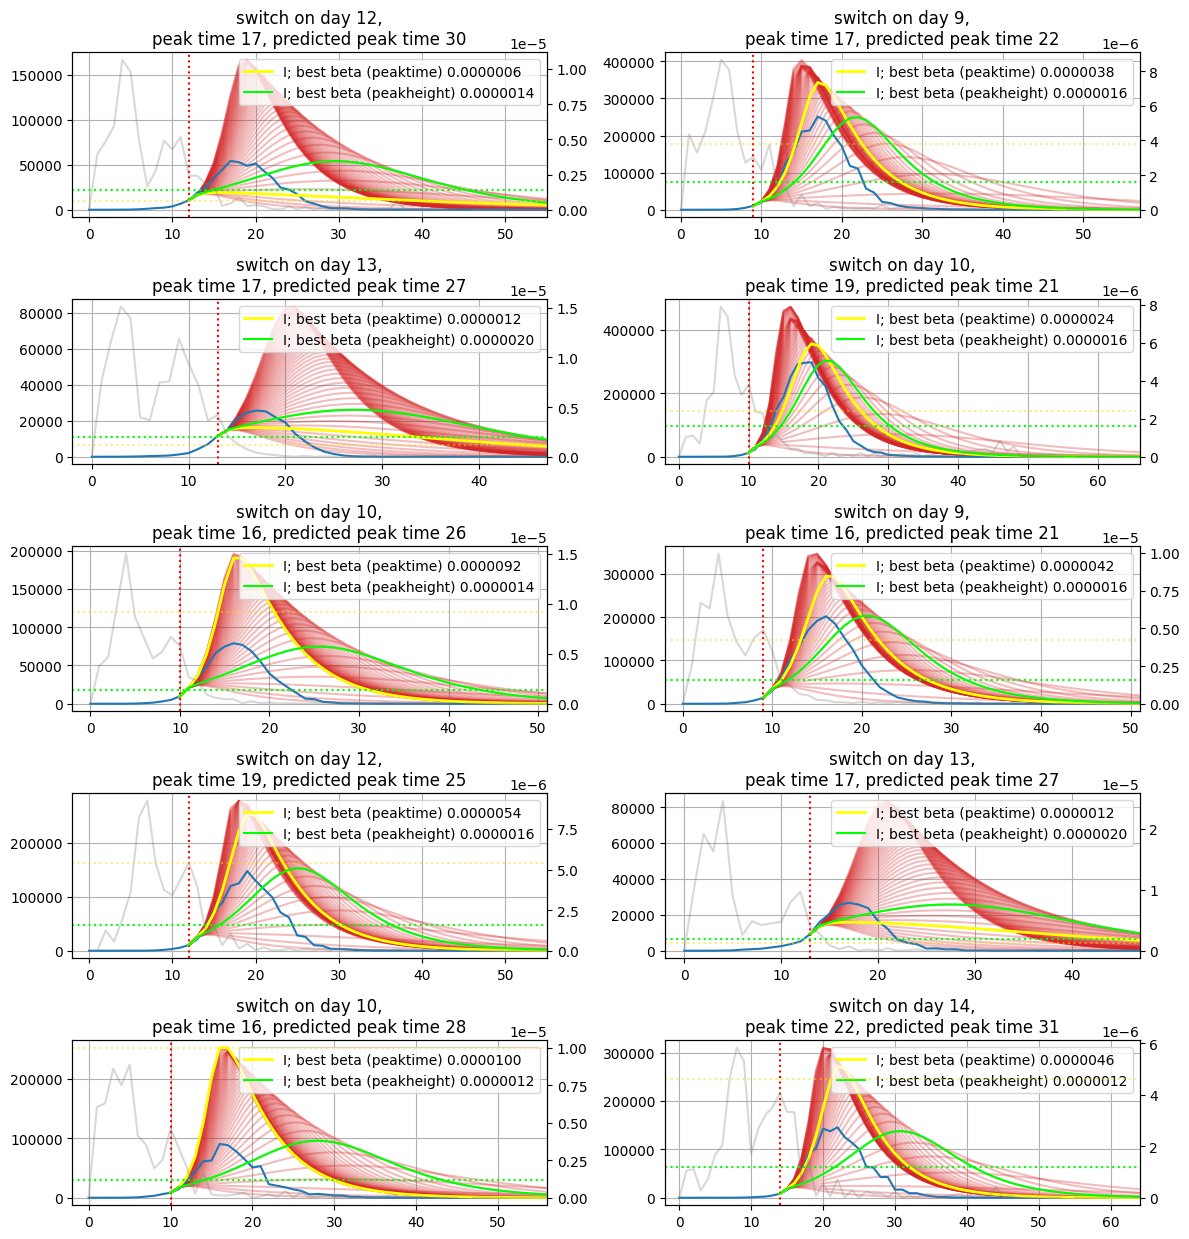

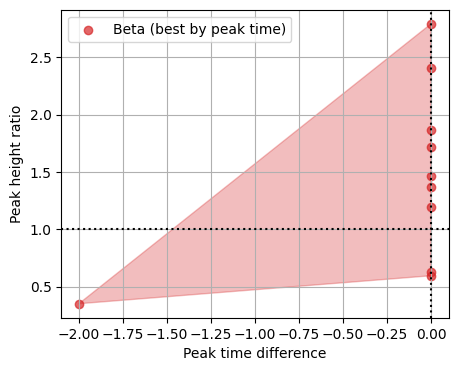

In [101]:
random.seed(42)

files =  [*X_train.values.flatten(), *X_val.values.flatten()]
files = np.array( random.sample(list(files), 10) )
switch.constant_betas_all(start_day='fraq_people', sigma=1/2, gamma=1/6,
                          files = files, plot=True, by_peak_='time')

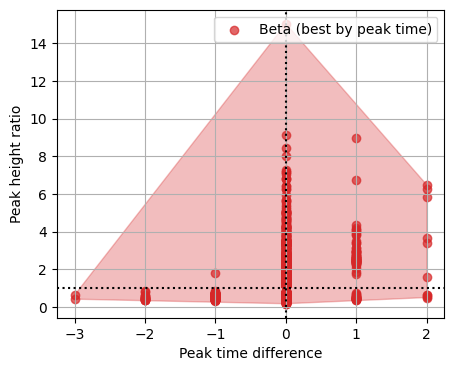

In [102]:
files =  np.array([*X_train.values.flatten(), *X_val.values.flatten()])
switch.constant_betas_all(start_day='fraq_people', sigma=1/2, gamma=1/6,
                          files = files, plot=False, by_peak_='time')

## real beta as input

0.01


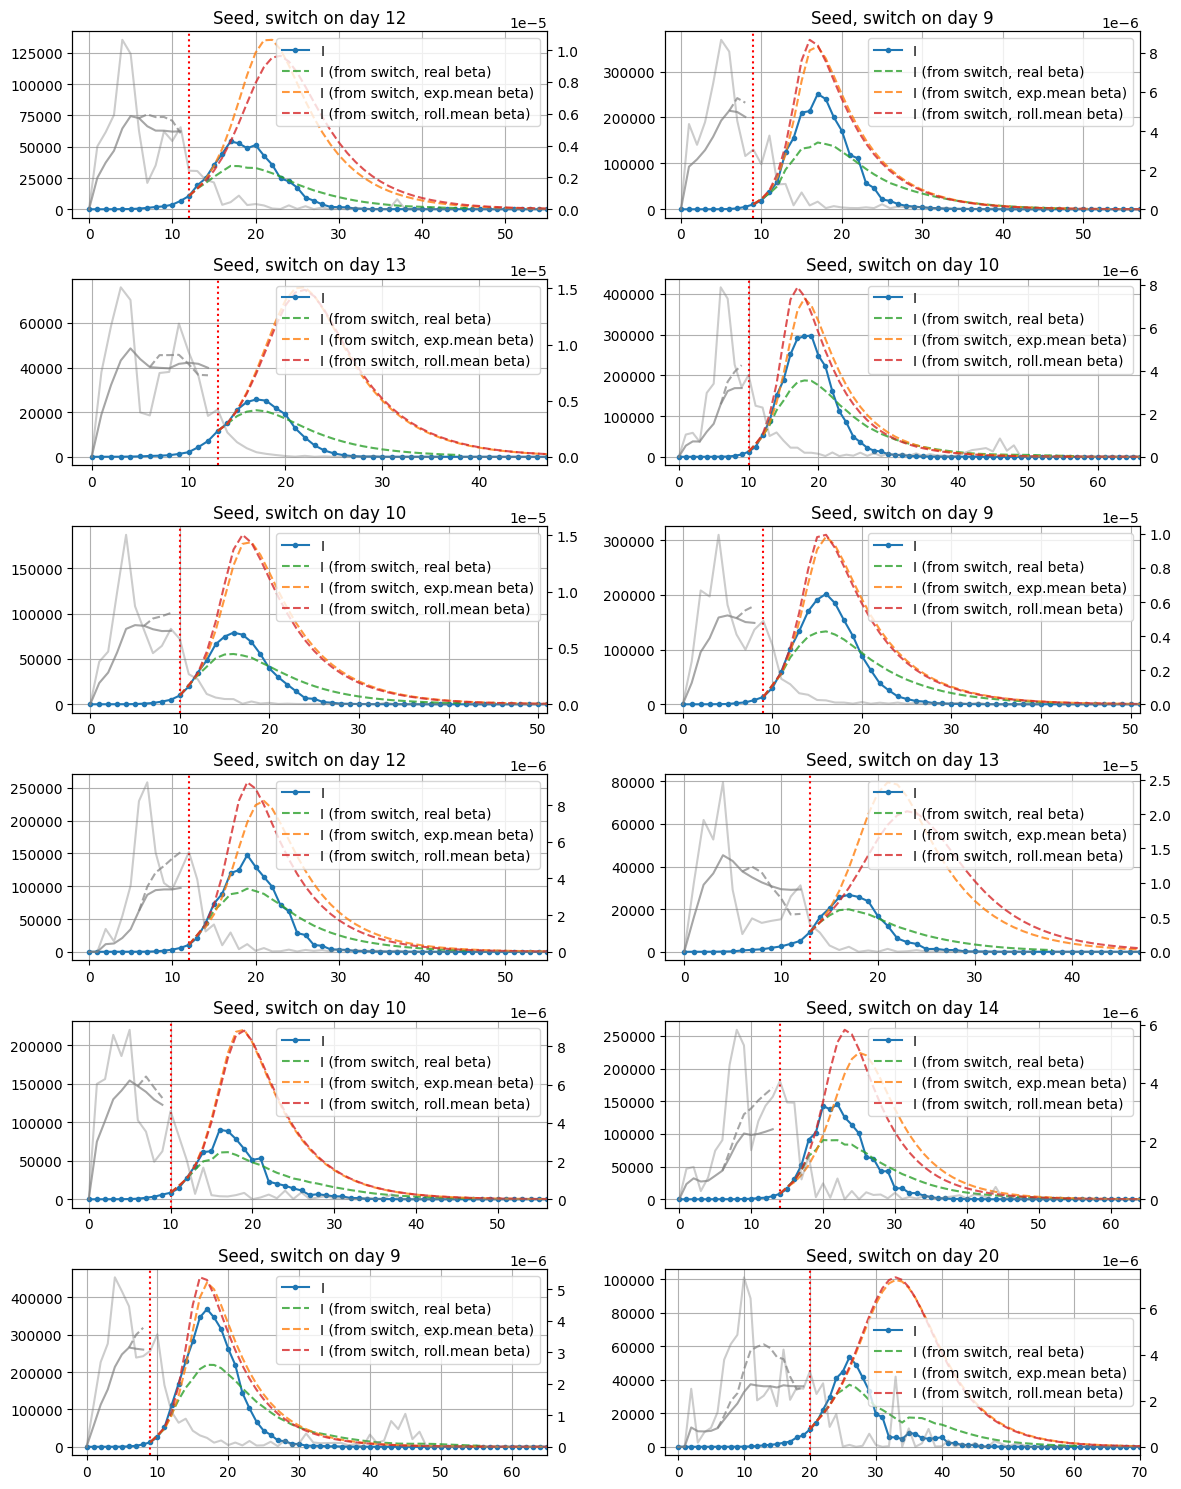

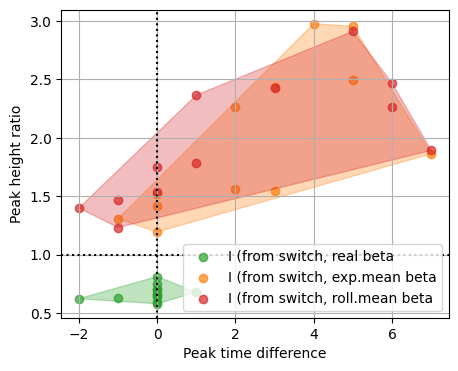

In [179]:
random.seed(42)

files =  [*X_train.values.flatten(), *X_val.values.flatten()]
files = np.array( random.sample(list(files), 12) )

r = switch.plot_hybrid_3(start_day='fraq_people', fraq=0.01,
                         sigma=1/2, gamma=1/6,
                         files=files)

0.02


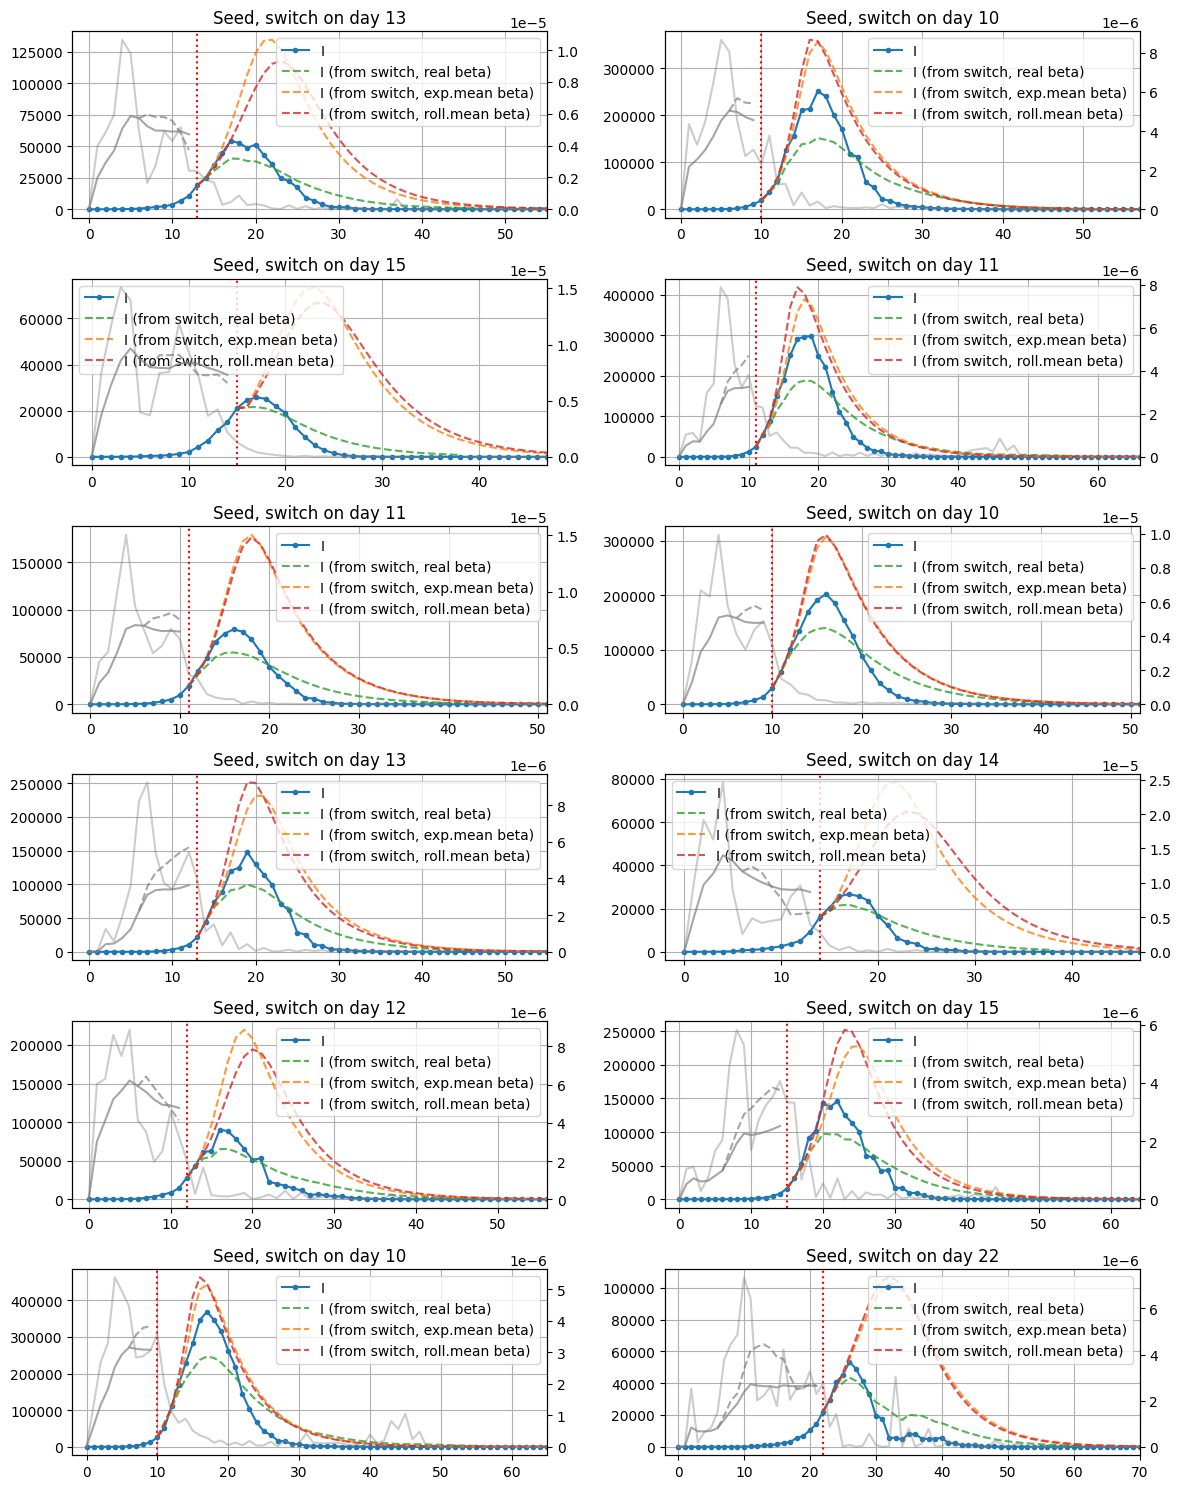

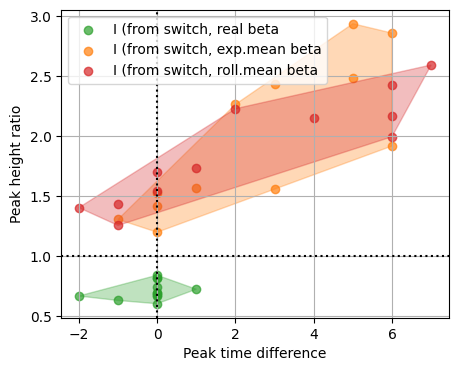

In [178]:
random.seed(42)

files =  [*X_train.values.flatten(), *X_val.values.flatten()]
files = np.array( random.sample(list(files), 12) )

r = switch.plot_hybrid_3(start_day='fraq_people', fraq=0.02,
                         sigma=1/2, gamma=1/6,
                         files=files)

In [181]:
np.array([*X_train.values.flatten(), *X_val.values.flatten()]).shape

(1303,)

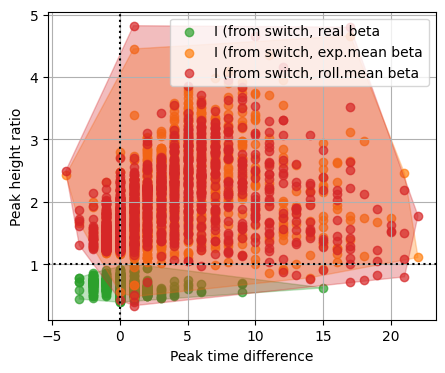

In [169]:
files =  np.array([*X_train.values.flatten(), *X_val.values.flatten()])

rr = switch.plot_hybrid_3(start_day='fraq_people', perc=0.01, 
                         sigma=1/2, gamma=1/6,
                         files=files, plot=False)

## checking real beta

пучок бет становится Уже, если переключаемся ближе к пику

реальная бета дает лучшее приближение, если переключаемся на 0-м дне??

далее лучше приближает бета*коэфф.; причем чем дальше переключение, тем больше нужен коэфф.

### one beta, diff.days

In [12]:
one_seed = X_train_all['file'].values.flatten()[10]

Text(0.5, 0, 'Days')

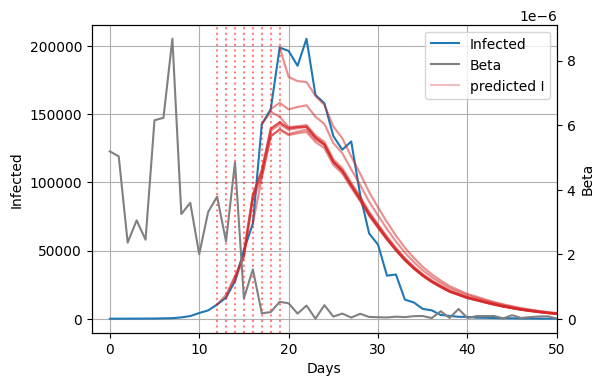

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax_b = ax.twinx()

df = pd.read_csv(one_seed)
l1 = ax.plot(df.I_H1N1, color='tab:blue', alpha=1, label='Infected')

seed_df = df.iloc[:,:5].copy()
seed_df.columns = ['S','E','I','R','Beta']
end_df  = seed_df[(seed_df.E==0)&(seed_df.I==0)]
if end_df.shape[0]:
    seed_df = seed_df.iloc[:end_df.index[0]].copy()

real_peakt = seed_df.I.argmax()
real_peakh = seed_df.I.max()
l2 = ax_b.plot(seed_df.Beta, color='gray', alpha=1, label='Beta')

for switch_day in range(12, 20):
#switch_day = choice_start_day.cpoint_fraq_people(seed_df, fraq=0.035)
    ax.axvline(switch_day, ls=':', color='red', alpha=0.5)   
    
    #switch_day=25
    y0 = seed_df.iloc[switch_day,:4].values
    ts = np.arange(seed_df.shape[0]-switch_day)

    sigma = 1/2
    gamma = 1/6

    res_dict = dict()

    b = seed_df.Beta[switch_day:].values
    S,E,I,R = seir_discrete.seir_model(y0, ts, b, 
                                       sigma, gamma, stype='d', 
                                       beta_t=True).T
    ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
            alpha=0.3)

    predicted_peakt = I.argmax()+switch_day
    predicted_peakh = I.max()
    pt_err = abs(real_peakt - predicted_peakt)
    ph_err = abs(real_peakh - predicted_peakh)

    l3 = ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
                    alpha=0.3, label='predicted I')

lns = l1+l2+l3
labs = [l.get_label() for l in lns]

leg = ax.legend(lns, labs)

 
ax.set_xlim(-2, 50)
ax.grid()    

ax.set_ylabel('Infected')
ax_b.set_ylabel('Beta')
ax.set_xlabel('Days')

### diff. beta (coeff 0.5--1.5), one day

#### 10

Text(0.5, 0, 'Days')

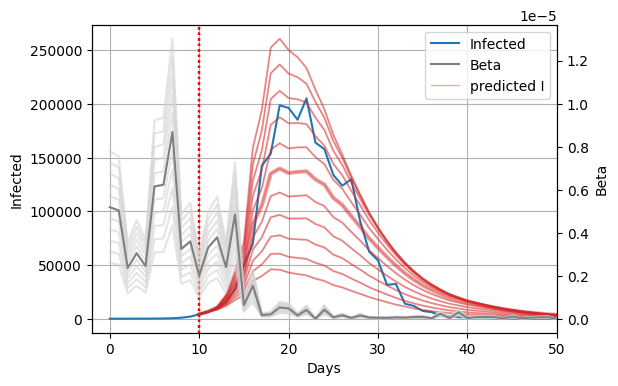

In [139]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax_b = ax.twinx()

df = pd.read_csv(one_seed)
l1 = ax.plot(df.I_H1N1, color='tab:blue', alpha=1, label='Infected')

seed_df = df.iloc[:,:5].copy()
seed_df.columns = ['S','E','I','R','Beta']
end_df  = seed_df[(seed_df.E==0)&(seed_df.I==0)]
if end_df.shape[0]:
    seed_df = seed_df.iloc[:end_df.index[0]].copy()

real_peakt = seed_df.I.argmax()
real_peakh = seed_df.I.max()


switch_day = 10

for coeff in range(-5, 6):
#switch_day = choice_start_day.cpoint_fraq_people(seed_df, fraq=0.035)
    ax.axvline(switch_day, ls=':', color='red', alpha=0.5)   
    
    #switch_day=25
    y0 = seed_df.iloc[switch_day,:4].values
    ts = np.arange(seed_df.shape[0]-switch_day)

    sigma = 1/2
    gamma = 1/6

    res_dict = dict()
    b = seed_df.Beta.values * (1 + coeff/10)
    ax_b.plot(b, color='lightgray', ls='-', alpha=0.6, label='Beta')
    S,E,I,R = seir_discrete.seir_model(y0, ts, b[switch_day:], 
                                       sigma, gamma, stype='d', 
                                       beta_t=True).T
    ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
            alpha=0.3)

    predicted_peakt = I.argmax()+switch_day
    predicted_peakh = I.max()
    pt_err = abs(real_peakt - predicted_peakt)
    ph_err = abs(real_peakh - predicted_peakh)

    if (1 + coeff/10) == 1:
        lw=3
    else:
        lw=1
        
    l3 = ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
                    alpha=0.4, label='predicted I', lw=lw)
    
l2 = ax_b.plot(seed_df.Beta, color='gray', alpha=1, label='Beta')
lns = l1+l2+l3
labs = [l.get_label() for l in lns]

leg = ax.legend(lns, labs)
 
ax.set_xlim(-2, 50)
ax.grid()    
ax.set_ylabel('Infected')
ax_b.set_ylabel('Beta')
ax.set_xlabel('Days')

#### 0

Text(0.5, 0, 'Days')

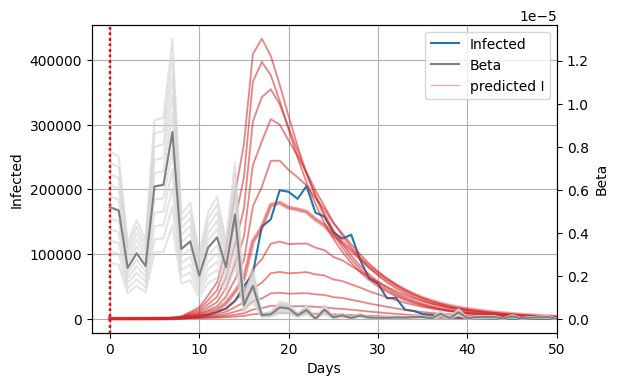

In [145]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax_b = ax.twinx()

df = pd.read_csv(one_seed)
l1 = ax.plot(df.I_H1N1, color='tab:blue', alpha=1, label='Infected')

seed_df = df.iloc[:,:5].copy()
seed_df.columns = ['S','E','I','R','Beta']
end_df  = seed_df[(seed_df.E==0)&(seed_df.I==0)]
if end_df.shape[0]:
    seed_df = seed_df.iloc[:end_df.index[0]].copy()

real_peakt = seed_df.I.argmax()
real_peakh = seed_df.I.max()


switch_day =0

for coeff in range(-5, 6):
#switch_day = choice_start_day.cpoint_fraq_people(seed_df, fraq=0.035)
    ax.axvline(switch_day, ls=':', color='red', alpha=0.5)   
    
    #switch_day=25
    y0 = seed_df.iloc[switch_day,:4].values
    ts = np.arange(seed_df.shape[0]-switch_day)

    sigma = 1/2
    gamma = 1/6

    res_dict = dict()
    b = seed_df.Beta.values * (1 + coeff/10)
    ax_b.plot(b, color='lightgray', ls='-', alpha=0.6, label='Beta')
    S,E,I,R = seir_discrete.seir_model(y0, ts, b[switch_day:], 
                                       sigma, gamma, stype='d', 
                                       beta_t=True).T
    ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
            alpha=0.3)

    predicted_peakt = I.argmax()+switch_day
    predicted_peakh = I.max()
    pt_err = abs(real_peakt - predicted_peakt)
    ph_err = abs(real_peakh - predicted_peakh)

    if (1 + coeff/10) == 1:
        lw=3
    else:
        lw=1
        
    l3 = ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
                    alpha=0.4, label='predicted I', lw=lw)
    
l2 = ax_b.plot(seed_df.Beta, color='gray', alpha=1, label='Beta')
lns = l1+l2+l3
labs = [l.get_label() for l in lns]

leg = ax.legend(lns, labs)
 
ax.set_xlim(-2, 50)
ax.grid()    
ax.set_ylabel('Infected')
ax_b.set_ylabel('Beta')
ax.set_xlabel('Days')

#### 5

In [153]:

for coeff in range(-5, 6):
    print((1 + coeff/10))

0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5


Text(0.5, 0, 'Days')

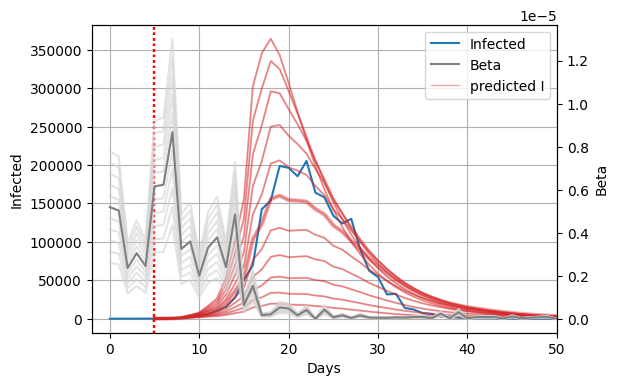

In [141]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax_b = ax.twinx()

df = pd.read_csv(one_seed)
l1 = ax.plot(df.I_H1N1, color='tab:blue', alpha=1, label='Infected')

seed_df = df.iloc[:,:5].copy()
seed_df.columns = ['S','E','I','R','Beta']
end_df  = seed_df[(seed_df.E==0)&(seed_df.I==0)]
if end_df.shape[0]:
    seed_df = seed_df.iloc[:end_df.index[0]].copy()

real_peakt = seed_df.I.argmax()
real_peakh = seed_df.I.max()


switch_day = 5

for coeff in range(-5, 6):
#switch_day = choice_start_day.cpoint_fraq_people(seed_df, fraq=0.035)
    ax.axvline(switch_day, ls=':', color='red', alpha=0.5)   
    
    #switch_day=25
    y0 = seed_df.iloc[switch_day,:4].values
    ts = np.arange(seed_df.shape[0]-switch_day)

    sigma = 1/2
    gamma = 1/6

    res_dict = dict()
    b = seed_df.Beta.values * (1 + coeff/10)
    ax_b.plot(b, color='lightgray', ls='-', alpha=0.6, label='Beta')
    S,E,I,R = seir_discrete.seir_model(y0, ts, b[switch_day:], 
                                       sigma, gamma, stype='d', 
                                       beta_t=True).T
    ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
            alpha=0.3)

    predicted_peakt = I.argmax()+switch_day
    predicted_peakh = I.max()
    pt_err = abs(real_peakt - predicted_peakt)
    ph_err = abs(real_peakh - predicted_peakh)

    if (1 + coeff/10) == 1:
        lw=3
    else:
        lw=1
        
    l3 = ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
                    alpha=0.4, label='predicted I', lw=lw)
    
l2 = ax_b.plot(seed_df.Beta, color='gray', alpha=1, label='Beta')
lns = l1+l2+l3
labs = [l.get_label() for l in lns]

leg = ax.legend(lns, labs)
 
ax.set_xlim(-2, 50)
ax.grid()    
ax.set_ylabel('Infected')
ax_b.set_ylabel('Beta')
ax.set_xlabel('Days')

#### 7

Text(0.5, 0, 'Days')

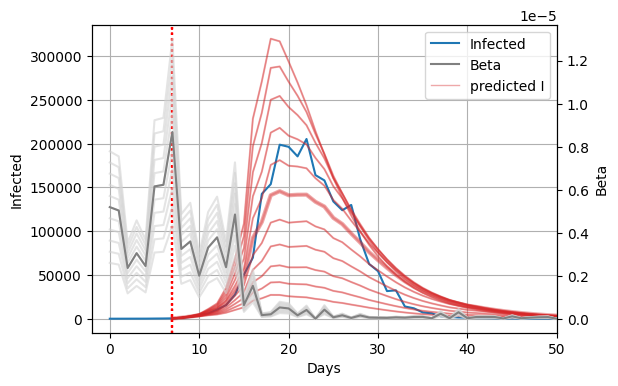

In [140]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax_b = ax.twinx()

df = pd.read_csv(one_seed)
l1 = ax.plot(df.I_H1N1, color='tab:blue', alpha=1, label='Infected')

seed_df = df.iloc[:,:5].copy()
seed_df.columns = ['S','E','I','R','Beta']
end_df  = seed_df[(seed_df.E==0)&(seed_df.I==0)]
if end_df.shape[0]:
    seed_df = seed_df.iloc[:end_df.index[0]].copy()

real_peakt = seed_df.I.argmax()
real_peakh = seed_df.I.max()


switch_day = 7

for coeff in range(-5, 6):
#switch_day = choice_start_day.cpoint_fraq_people(seed_df, fraq=0.035)
    ax.axvline(switch_day, ls=':', color='red', alpha=0.5)   
    
    #switch_day=25
    y0 = seed_df.iloc[switch_day,:4].values
    ts = np.arange(seed_df.shape[0]-switch_day)

    sigma = 1/2
    gamma = 1/6

    res_dict = dict()
    b = seed_df.Beta.values * (1 + coeff/10)
    ax_b.plot(b, color='lightgray', ls='-', alpha=0.6, label='Beta')
    S,E,I,R = seir_discrete.seir_model(y0, ts, b[switch_day:], 
                                       sigma, gamma, stype='d', 
                                       beta_t=True).T
    ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
            alpha=0.3)

    predicted_peakt = I.argmax()+switch_day
    predicted_peakh = I.max()
    pt_err = abs(real_peakt - predicted_peakt)
    ph_err = abs(real_peakh - predicted_peakh)

    if (1 + coeff/10) == 1:
        lw=3
    else:
        lw=1
        
    l3 = ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
                    alpha=0.4, label='predicted I', lw=lw)
    
l2 = ax_b.plot(seed_df.Beta, color='gray', alpha=1, label='Beta')
lns = l1+l2+l3
labs = [l.get_label() for l in lns]

leg = ax.legend(lns, labs)
 
ax.set_xlim(-2, 50)
ax.grid()    
ax.set_ylabel('Infected')
ax_b.set_ylabel('Beta')
ax.set_xlabel('Days')

#### 12

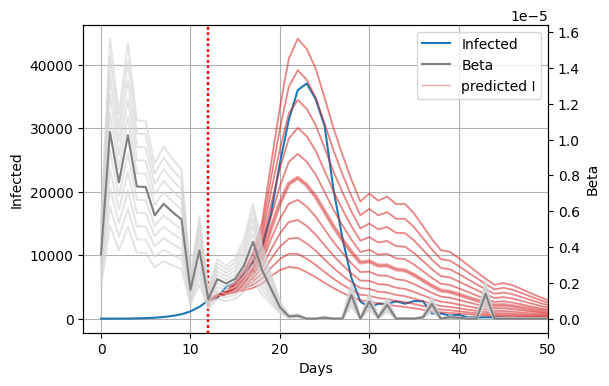

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax_b = ax.twinx()

df = pd.read_csv(one_seed)
l1 = ax.plot(df.I_H1N1, color='tab:blue', alpha=1, label='Infected')

seed_df = df.iloc[:,:5].copy()
seed_df.columns = ['S','E','I','R','Beta']
end_df  = seed_df[(seed_df.E==0)&(seed_df.I==0)]
if end_df.shape[0]:
    seed_df = seed_df.iloc[:end_df.index[0]].copy()

real_peakt = seed_df.I.argmax()
real_peakh = seed_df.I.max()


switch_day = 12

for coeff in range(-5, 6):
#switch_day = choice_start_day.cpoint_fraq_people(seed_df, fraq=0.035)
    ax.axvline(switch_day, ls=':', color='red', alpha=0.5)   
    
    #switch_day=25
    y0 = seed_df.iloc[switch_day,:4].values
    ts = np.arange(seed_df.shape[0]-switch_day)

    sigma = 1/2
    gamma = 1/6

    res_dict = dict()
    b = seed_df.Beta.values * (1 + coeff/10)
    ax_b.plot(b, color='lightgray', ls='-', alpha=0.6, label='Beta')
    S,E,I,R = seir_discrete.seir_model(y0, ts, b[switch_day:], 
                                       sigma, gamma, stype='d', 
                                       beta_t=True).T
    ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
            alpha=0.3)

    predicted_peakt = I.argmax()+switch_day
    predicted_peakh = I.max()
    pt_err = abs(real_peakt - predicted_peakt)
    ph_err = abs(real_peakh - predicted_peakh)

    if (1 + coeff/10) == 1:
        lw=3
    else:
        lw=1
        
    l3 = ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
                    alpha=0.4, label='predicted I', lw=lw)
    
l2 = ax_b.plot(seed_df.Beta, color='gray', alpha=1, label='Beta')
lns = l1+l2+l3
labs = [l.get_label() for l in lns]

leg = ax.legend(lns, labs)
 
ax.set_xlim(-2, 50)
ax.grid()    
ax.set_ylabel('Infected')
ax_b.set_ylabel('Beta')
ax.set_xlabel('Days')

plt.savefig(f'results/coeffs_real_beta.pdf', 
            format='pdf', bbox_inches='tight')

Text(0.5, 0, 'Days')

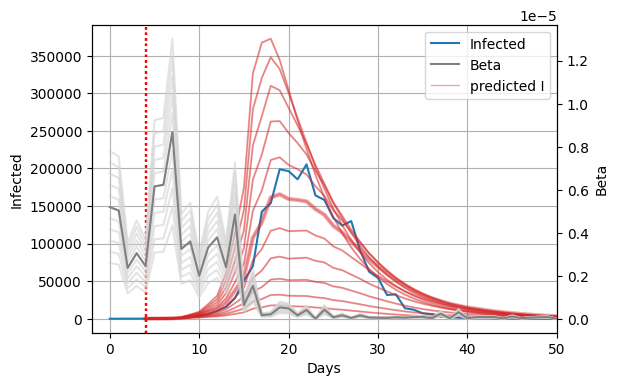

In [154]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax_b = ax.twinx()

df = pd.read_csv(one_seed)
l1 = ax.plot(df.I_H1N1, color='tab:blue', alpha=1, label='Infected')

seed_df = df.iloc[:,:5].copy()
seed_df.columns = ['S','E','I','R','Beta']
end_df  = seed_df[(seed_df.E==0)&(seed_df.I==0)]
if end_df.shape[0]:
    seed_df = seed_df.iloc[:end_df.index[0]].copy()

real_peakt = seed_df.I.argmax()
real_peakh = seed_df.I.max()


switch_day = 4

for coeff in range(-5, 6):
#switch_day = choice_start_day.cpoint_fraq_people(seed_df, fraq=0.035)
    ax.axvline(switch_day, ls=':', color='red', alpha=0.5)   
    
    #switch_day=25
    y0 = seed_df.iloc[switch_day,:4].values
    ts = np.arange(seed_df.shape[0]-switch_day)

    sigma = 1/2
    gamma = 1/6

    res_dict = dict()
    b = seed_df.Beta.values * (1 + coeff/10)
    ax_b.plot(b, color='lightgray', ls='-', alpha=0.6, label='Beta')
    S,E,I,R = seir_discrete.seir_model(y0, ts, b[switch_day:], 
                                       sigma, gamma, stype='d', 
                                       beta_t=True).T
    ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
            alpha=0.3)

    predicted_peakt = I.argmax()+switch_day
    predicted_peakh = I.max()
    pt_err = abs(real_peakt - predicted_peakt)
    ph_err = abs(real_peakh - predicted_peakh)

    if (1 + coeff/10) == 1:
        lw=3
    else:
        lw=1
        
    l3 = ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
                    alpha=0.4, label='predicted I', lw=lw)
    
l2 = ax_b.plot(seed_df.Beta, color='gray', alpha=1, label='Beta')
lns = l1+l2+l3
labs = [l.get_label() for l in lns]

leg = ax.legend(lns, labs)
 
ax.set_xlim(-2, 50)
ax.grid()    
ax.set_ylabel('Infected')
ax_b.set_ylabel('Beta')
ax.set_xlabel('Days')

Text(0.5, 0, 'Days')

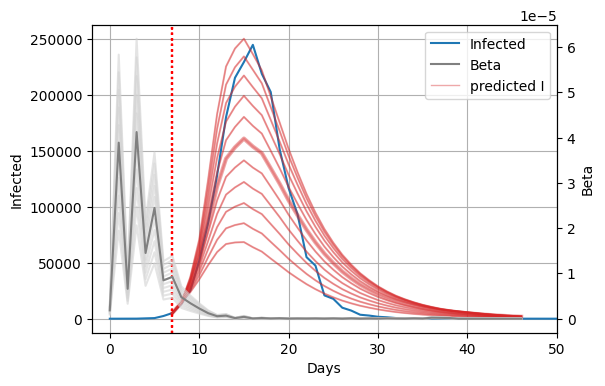

In [170]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax_b = ax.twinx()

one_seed = X_train_all['file'].values.flatten()[20]
df = pd.read_csv(one_seed)
l1 = ax.plot(df.I_H1N1, color='tab:blue', alpha=1, label='Infected')

seed_df = df.iloc[:,:5].copy()
seed_df.columns = ['S','E','I','R','Beta']
end_df  = seed_df[(seed_df.E==0)&(seed_df.I==0)]
if end_df.shape[0]:
    seed_df = seed_df.iloc[:end_df.index[0]].copy()

real_peakt = seed_df.I.argmax()
real_peakh = seed_df.I.max()


switch_day = 7

for coeff in range(-5, 6):
#switch_day = choice_start_day.cpoint_fraq_people(seed_df, fraq=0.035)
    ax.axvline(switch_day, ls=':', color='red', alpha=0.5)   
    
    #switch_day=25
    y0 = seed_df.iloc[switch_day,:4].values
    ts = np.arange(seed_df.shape[0]-switch_day)

    sigma = 1/2
    gamma = 1/6

    res_dict = dict()
    b = seed_df.Beta.values * (1 + coeff/10)
    ax_b.plot(b, color='lightgray', ls='-', alpha=0.6, label='Beta')
    S,E,I,R = seir_discrete.seir_model(y0, ts, b[switch_day:], 
                                       sigma, gamma, stype='d', 
                                       beta_t=True).T
    ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
            alpha=0.3)

    predicted_peakt = I.argmax()+switch_day
    predicted_peakh = I.max()
    pt_err = abs(real_peakt - predicted_peakt)
    ph_err = abs(real_peakh - predicted_peakh)

    if (1 + coeff/10) == 1:
        lw=3
    else:
        lw=1
        
    l3 = ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
                    alpha=0.4, label='predicted I', lw=lw)
    
l2 = ax_b.plot(seed_df.Beta, color='gray', alpha=1, label='Beta')
lns = l1+l2+l3
labs = [l.get_label() for l in lns]

leg = ax.legend(lns, labs)
 
ax.set_xlim(-2, 50)
ax.grid()    
ax.set_ylabel('Infected')
ax_b.set_ylabel('Beta')
ax.set_xlabel('Days')

Text(0.5, 0, 'Days')

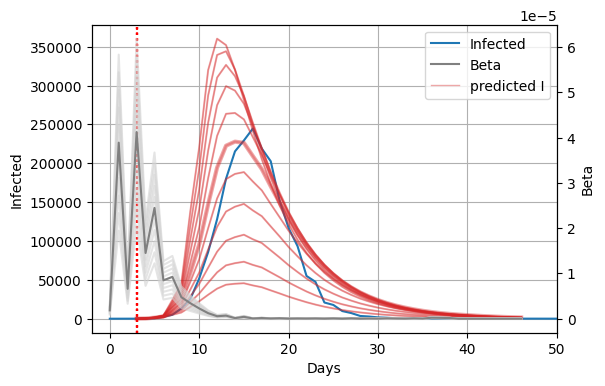

In [172]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax_b = ax.twinx()

one_seed = X_train_all['file'].values.flatten()[20]
df = pd.read_csv(one_seed)
l1 = ax.plot(df.I_H1N1, color='tab:blue', alpha=1, label='Infected')

seed_df = df.iloc[:,:5].copy()
seed_df.columns = ['S','E','I','R','Beta']
end_df  = seed_df[(seed_df.E==0)&(seed_df.I==0)]
if end_df.shape[0]:
    seed_df = seed_df.iloc[:end_df.index[0]].copy()

real_peakt = seed_df.I.argmax()
real_peakh = seed_df.I.max()


switch_day = 3

for coeff in range(-5, 6):
#switch_day = choice_start_day.cpoint_fraq_people(seed_df, fraq=0.035)
    ax.axvline(switch_day, ls=':', color='red', alpha=0.5)   
    
    #switch_day=25
    y0 = seed_df.iloc[switch_day,:4].values
    ts = np.arange(seed_df.shape[0]-switch_day)

    sigma = 1/2
    gamma = 1/6

    res_dict = dict()
    b = seed_df.Beta.values * (1 + coeff/10)
    ax_b.plot(b, color='lightgray', ls='-', alpha=0.6, label='Beta')
    S,E,I,R = seir_discrete.seir_model(y0, ts, b[switch_day:], 
                                       sigma, gamma, stype='d', 
                                       beta_t=True).T
    ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
            alpha=0.3)

    predicted_peakt = I.argmax()+switch_day
    predicted_peakh = I.max()
    pt_err = abs(real_peakt - predicted_peakt)
    ph_err = abs(real_peakh - predicted_peakh)

    if (1 + coeff/10) == 1:
        lw=3
    else:
        lw=1
        
    l3 = ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
                    alpha=0.4, label='predicted I', lw=lw)
    
l2 = ax_b.plot(seed_df.Beta, color='gray', alpha=1, label='Beta')
lns = l1+l2+l3
labs = [l.get_label() for l in lns]

leg = ax.legend(lns, labs)
 
ax.set_xlim(-2, 50)
ax.grid()    
ax.set_ylabel('Infected')
ax_b.set_ylabel('Beta')
ax.set_xlabel('Days')

Text(0.5, 0, 'Days')

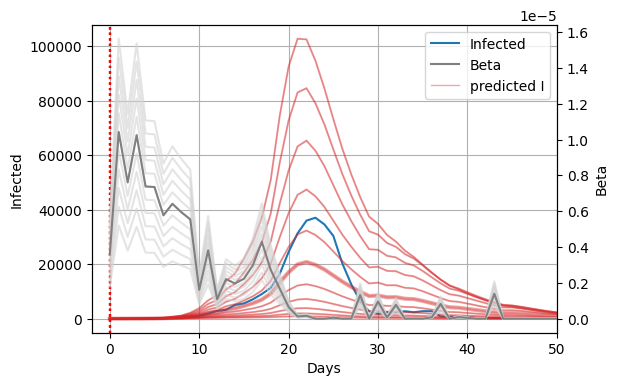

In [173]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax_b = ax.twinx()

one_seed = X_train_all['file'].values.flatten()[30]
df = pd.read_csv(one_seed)
l1 = ax.plot(df.I_H1N1, color='tab:blue', alpha=1, label='Infected')

seed_df = df.iloc[:,:5].copy()
seed_df.columns = ['S','E','I','R','Beta']
end_df  = seed_df[(seed_df.E==0)&(seed_df.I==0)]
if end_df.shape[0]:
    seed_df = seed_df.iloc[:end_df.index[0]].copy()

real_peakt = seed_df.I.argmax()
real_peakh = seed_df.I.max()


switch_day = 0

for coeff in range(-5, 6):
#switch_day = choice_start_day.cpoint_fraq_people(seed_df, fraq=0.035)
    ax.axvline(switch_day, ls=':', color='red', alpha=0.5)   
    
    #switch_day=25
    y0 = seed_df.iloc[switch_day,:4].values
    ts = np.arange(seed_df.shape[0]-switch_day)

    sigma = 1/2
    gamma = 1/6

    res_dict = dict()
    b = seed_df.Beta.values * (1 + coeff/10)
    ax_b.plot(b, color='lightgray', ls='-', alpha=0.6, label='Beta')
    S,E,I,R = seir_discrete.seir_model(y0, ts, b[switch_day:], 
                                       sigma, gamma, stype='d', 
                                       beta_t=True).T
    ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
            alpha=0.3)

    predicted_peakt = I.argmax()+switch_day
    predicted_peakh = I.max()
    pt_err = abs(real_peakt - predicted_peakt)
    ph_err = abs(real_peakh - predicted_peakh)

    if (1 + coeff/10) == 1:
        lw=3
    else:
        lw=1
        
    l3 = ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
                    alpha=0.4, label='predicted I', lw=lw)
    
l2 = ax_b.plot(seed_df.Beta, color='gray', alpha=1, label='Beta')
lns = l1+l2+l3
labs = [l.get_label() for l in lns]

leg = ax.legend(lns, labs)
 
ax.set_xlim(-2, 50)
ax.grid()    
ax.set_ylabel('Infected')
ax_b.set_ylabel('Beta')
ax.set_xlabel('Days')

Text(0.5, 0, 'Days')

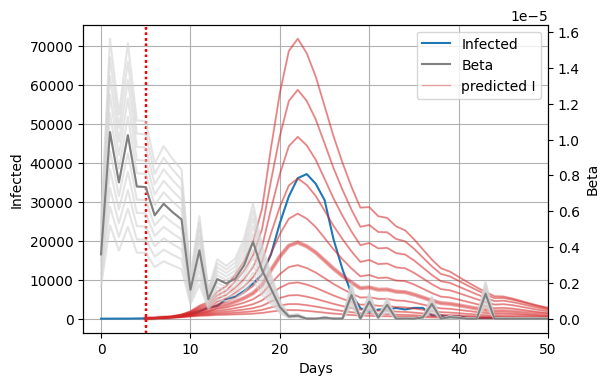

In [174]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax_b = ax.twinx()

one_seed = X_train_all['file'].values.flatten()[30]
df = pd.read_csv(one_seed)
l1 = ax.plot(df.I_H1N1, color='tab:blue', alpha=1, label='Infected')

seed_df = df.iloc[:,:5].copy()
seed_df.columns = ['S','E','I','R','Beta']
end_df  = seed_df[(seed_df.E==0)&(seed_df.I==0)]
if end_df.shape[0]:
    seed_df = seed_df.iloc[:end_df.index[0]].copy()

real_peakt = seed_df.I.argmax()
real_peakh = seed_df.I.max()


switch_day = 5

for coeff in range(-5, 6):
#switch_day = choice_start_day.cpoint_fraq_people(seed_df, fraq=0.035)
    ax.axvline(switch_day, ls=':', color='red', alpha=0.5)   
    
    #switch_day=25
    y0 = seed_df.iloc[switch_day,:4].values
    ts = np.arange(seed_df.shape[0]-switch_day)

    sigma = 1/2
    gamma = 1/6

    res_dict = dict()
    b = seed_df.Beta.values * (1 + coeff/10)
    ax_b.plot(b, color='lightgray', ls='-', alpha=0.6, label='Beta')
    S,E,I,R = seir_discrete.seir_model(y0, ts, b[switch_day:], 
                                       sigma, gamma, stype='d', 
                                       beta_t=True).T
    ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
            alpha=0.3)

    predicted_peakt = I.argmax()+switch_day
    predicted_peakh = I.max()
    pt_err = abs(real_peakt - predicted_peakt)
    ph_err = abs(real_peakh - predicted_peakh)

    if (1 + coeff/10) == 1:
        lw=3
    else:
        lw=1
        
    l3 = ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
                    alpha=0.4, label='predicted I', lw=lw)
    
l2 = ax_b.plot(seed_df.Beta, color='gray', alpha=1, label='Beta')
lns = l1+l2+l3
labs = [l.get_label() for l in lns]

leg = ax.legend(lns, labs)
 
ax.set_xlim(-2, 50)
ax.grid()    
ax.set_ylabel('Infected')
ax_b.set_ylabel('Beta')
ax.set_xlabel('Days')

Text(0.5, 0, 'Days')

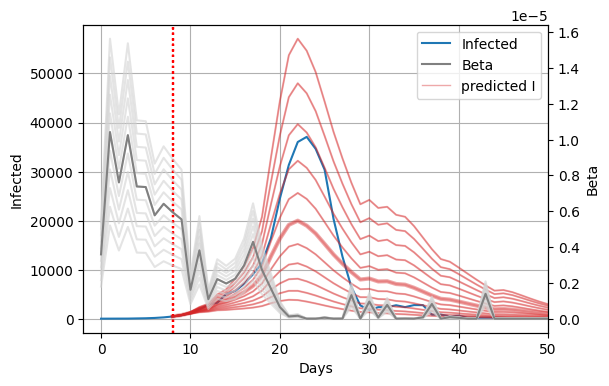

In [175]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax_b = ax.twinx()

one_seed = X_train_all['file'].values.flatten()[30]
df = pd.read_csv(one_seed)
l1 = ax.plot(df.I_H1N1, color='tab:blue', alpha=1, label='Infected')

seed_df = df.iloc[:,:5].copy()
seed_df.columns = ['S','E','I','R','Beta']
end_df  = seed_df[(seed_df.E==0)&(seed_df.I==0)]
if end_df.shape[0]:
    seed_df = seed_df.iloc[:end_df.index[0]].copy()

real_peakt = seed_df.I.argmax()
real_peakh = seed_df.I.max()


switch_day = 8

for coeff in range(-5, 6):
#switch_day = choice_start_day.cpoint_fraq_people(seed_df, fraq=0.035)
    ax.axvline(switch_day, ls=':', color='red', alpha=0.5)   
    
    #switch_day=25
    y0 = seed_df.iloc[switch_day,:4].values
    ts = np.arange(seed_df.shape[0]-switch_day)

    sigma = 1/2
    gamma = 1/6

    res_dict = dict()
    b = seed_df.Beta.values * (1 + coeff/10)
    ax_b.plot(b, color='lightgray', ls='-', alpha=0.6, label='Beta')
    S,E,I,R = seir_discrete.seir_model(y0, ts, b[switch_day:], 
                                       sigma, gamma, stype='d', 
                                       beta_t=True).T
    ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
            alpha=0.3)

    predicted_peakt = I.argmax()+switch_day
    predicted_peakh = I.max()
    pt_err = abs(real_peakt - predicted_peakt)
    ph_err = abs(real_peakh - predicted_peakh)

    if (1 + coeff/10) == 1:
        lw=3
    else:
        lw=1
        
    l3 = ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
                    alpha=0.4, label='predicted I', lw=lw)
    
l2 = ax_b.plot(seed_df.Beta, color='gray', alpha=1, label='Beta')
lns = l1+l2+l3
labs = [l.get_label() for l in lns]

leg = ax.legend(lns, labs)
 
ax.set_xlim(-2, 50)
ax.grid()    
ax.set_ylabel('Infected')
ax_b.set_ylabel('Beta')
ax.set_xlabel('Days')

Text(0.5, 0, 'Days')

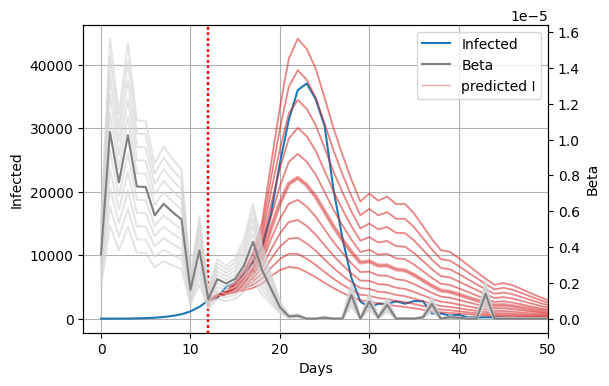

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax_b = ax.twinx()

one_seed = X_train_all['file'].values.flatten()[30]
df = pd.read_csv(one_seed)
l1 = ax.plot(df.I_H1N1, color='tab:blue', alpha=1, label='Infected')

seed_df = df.iloc[:,:5].copy()
seed_df.columns = ['S','E','I','R','Beta']
end_df  = seed_df[(seed_df.E==0)&(seed_df.I==0)]
if end_df.shape[0]:
    seed_df = seed_df.iloc[:end_df.index[0]].copy()

real_peakt = seed_df.I.argmax()
real_peakh = seed_df.I.max()


switch_day = 12

for coeff in range(-5, 6):
#switch_day = choice_start_day.cpoint_fraq_people(seed_df, fraq=0.035)
    ax.axvline(switch_day, ls=':', color='red', alpha=0.5)   
    
    #switch_day=25
    y0 = seed_df.iloc[switch_day,:4].values
    ts = np.arange(seed_df.shape[0]-switch_day)

    sigma = 1/2
    gamma = 1/6

    res_dict = dict()
    b = seed_df.Beta.values * (1 + coeff/10)
    ax_b.plot(b, color='lightgray', ls='-', alpha=0.6, label='Beta')
    S,E,I,R = seir_discrete.seir_model(y0, ts, b[switch_day:], 
                                       sigma, gamma, stype='d', 
                                       beta_t=True).T
    ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
            alpha=0.3)

    predicted_peakt = I.argmax()+switch_day
    predicted_peakh = I.max()
    pt_err = abs(real_peakt - predicted_peakt)
    ph_err = abs(real_peakh - predicted_peakh)

    if (1 + coeff/10) == 1:
        lw=3
    else:
        lw=1
        
    l3 = ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
                    alpha=0.4, label='predicted I', lw=lw)
    
l2 = ax_b.plot(seed_df.Beta, color='gray', alpha=1, label='Beta')
lns = l1+l2+l3
labs = [l.get_label() for l in lns]

leg = ax.legend(lns, labs)
 
ax.set_xlim(-2, 50)
ax.grid()    
ax.set_ylabel('Infected')
ax_b.set_ylabel('Beta')
ax.set_xlabel('Days')

Text(0.5, 0, 'Days')

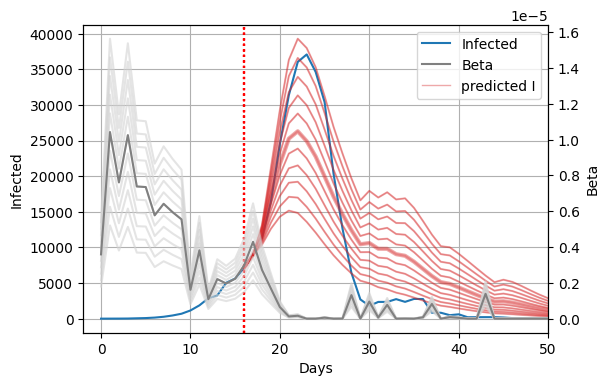

In [177]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax_b = ax.twinx()

one_seed = X_train_all['file'].values.flatten()[30]
df = pd.read_csv(one_seed)
l1 = ax.plot(df.I_H1N1, color='tab:blue', alpha=1, label='Infected')

seed_df = df.iloc[:,:5].copy()
seed_df.columns = ['S','E','I','R','Beta']
end_df  = seed_df[(seed_df.E==0)&(seed_df.I==0)]
if end_df.shape[0]:
    seed_df = seed_df.iloc[:end_df.index[0]].copy()

real_peakt = seed_df.I.argmax()
real_peakh = seed_df.I.max()


switch_day = 16

for coeff in range(-5, 6):
#switch_day = choice_start_day.cpoint_fraq_people(seed_df, fraq=0.035)
    ax.axvline(switch_day, ls=':', color='red', alpha=0.5)   
    
    #switch_day=25
    y0 = seed_df.iloc[switch_day,:4].values
    ts = np.arange(seed_df.shape[0]-switch_day)

    sigma = 1/2
    gamma = 1/6

    res_dict = dict()
    b = seed_df.Beta.values * (1 + coeff/10)
    ax_b.plot(b, color='lightgray', ls='-', alpha=0.6, label='Beta')
    S,E,I,R = seir_discrete.seir_model(y0, ts, b[switch_day:], 
                                       sigma, gamma, stype='d', 
                                       beta_t=True).T
    ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
            alpha=0.3)

    predicted_peakt = I.argmax()+switch_day
    predicted_peakh = I.max()
    pt_err = abs(real_peakt - predicted_peakt)
    ph_err = abs(real_peakh - predicted_peakh)

    if (1 + coeff/10) == 1:
        lw=3
    else:
        lw=1
        
    l3 = ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
                    alpha=0.4, label='predicted I', lw=lw)
    
l2 = ax_b.plot(seed_df.Beta, color='gray', alpha=1, label='Beta')
lns = l1+l2+l3
labs = [l.get_label() for l in lns]

leg = ax.legend(lns, labs)
 
ax.set_xlim(-2, 50)
ax.grid()    
ax.set_ylabel('Infected')
ax_b.set_ylabel('Beta')
ax.set_xlabel('Days')

Text(0.5, 0, 'Days')

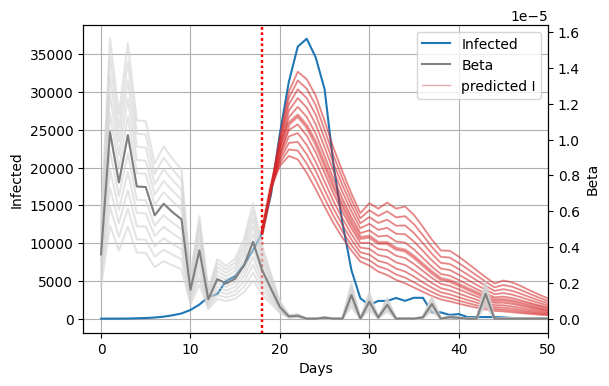

In [178]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax_b = ax.twinx()

one_seed = X_train_all['file'].values.flatten()[30]
df = pd.read_csv(one_seed)
l1 = ax.plot(df.I_H1N1, color='tab:blue', alpha=1, label='Infected')

seed_df = df.iloc[:,:5].copy()
seed_df.columns = ['S','E','I','R','Beta']
end_df  = seed_df[(seed_df.E==0)&(seed_df.I==0)]
if end_df.shape[0]:
    seed_df = seed_df.iloc[:end_df.index[0]].copy()

real_peakt = seed_df.I.argmax()
real_peakh = seed_df.I.max()


switch_day = 18

for coeff in range(-5, 6):
#switch_day = choice_start_day.cpoint_fraq_people(seed_df, fraq=0.035)
    ax.axvline(switch_day, ls=':', color='red', alpha=0.5)   
    
    #switch_day=25
    y0 = seed_df.iloc[switch_day,:4].values
    ts = np.arange(seed_df.shape[0]-switch_day)

    sigma = 1/2
    gamma = 1/6

    res_dict = dict()
    b = seed_df.Beta.values * (1 + coeff/10)
    ax_b.plot(b, color='lightgray', ls='-', alpha=0.6, label='Beta')
    S,E,I,R = seir_discrete.seir_model(y0, ts, b[switch_day:], 
                                       sigma, gamma, stype='d', 
                                       beta_t=True).T
    ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
            alpha=0.3)

    predicted_peakt = I.argmax()+switch_day
    predicted_peakh = I.max()
    pt_err = abs(real_peakt - predicted_peakt)
    ph_err = abs(real_peakh - predicted_peakh)

    if (1 + coeff/10) == 1:
        lw=3
    else:
        lw=1
        
    l3 = ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
                    alpha=0.4, label='predicted I', lw=lw)
    
l2 = ax_b.plot(seed_df.Beta, color='gray', alpha=1, label='Beta')
lns = l1+l2+l3
labs = [l.get_label() for l in lns]

leg = ax.legend(lns, labs)
 
ax.set_xlim(-2, 50)
ax.grid()    
ax.set_ylabel('Infected')
ax_b.set_ylabel('Beta')
ax.set_xlabel('Days')

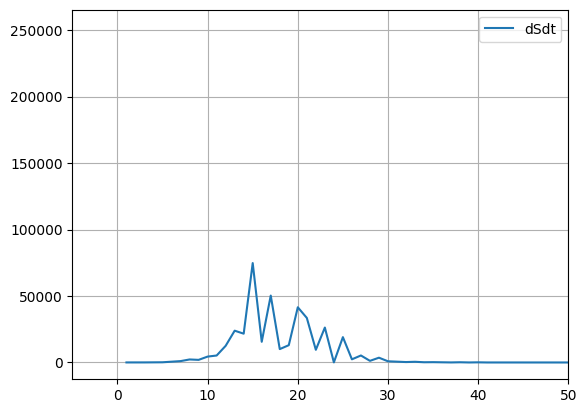

In [167]:
(-df.S_H1N1.diff()).plot(label='dSdt')
plt.xlim(-5,50)
plt.legend()
plt.grid()

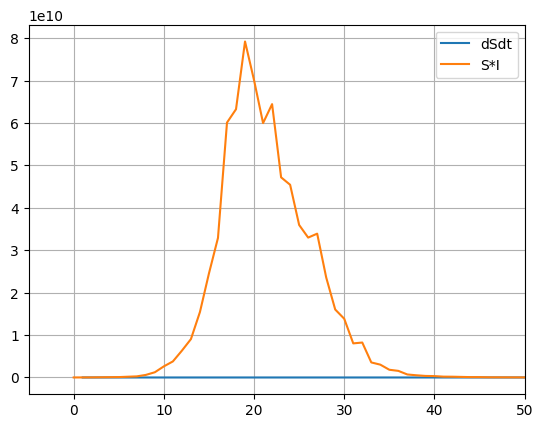

In [165]:
(-df.S_H1N1.diff()).plot(label='dSdt')
(df.S_H1N1*df.I_H1N1).plot(label='S*I')

plt.xlim(-5,50)
plt.legend()
plt.grid()

In [164]:
-df.S_H1N1.diff()

0        NaN
1       33.0
2       32.0
3       48.0
4      126.0
       ...  
245     -0.0
246     -0.0
247     -0.0
248     -0.0
249     -0.0
Name: S_H1N1, Length: 250, dtype: float64

#### 13

Text(0.5, 0, 'Days')

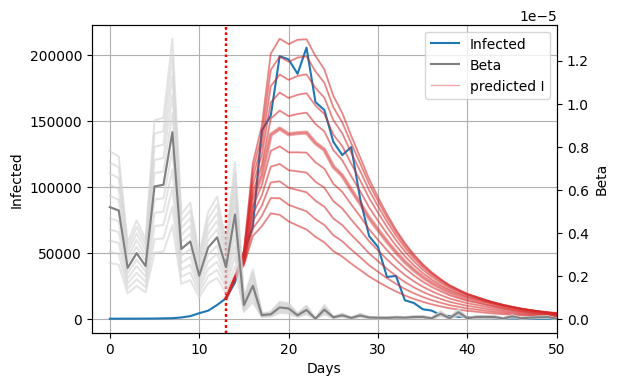

In [136]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax_b = ax.twinx()

df = pd.read_csv(one_seed)
l1 = ax.plot(df.I_H1N1, color='tab:blue', alpha=1, label='Infected')

seed_df = df.iloc[:,:5].copy()
seed_df.columns = ['S','E','I','R','Beta']
end_df  = seed_df[(seed_df.E==0)&(seed_df.I==0)]
if end_df.shape[0]:
    seed_df = seed_df.iloc[:end_df.index[0]].copy()

real_peakt = seed_df.I.argmax()
real_peakh = seed_df.I.max()


switch_day = 13

for coeff in range(-5, 6):
#switch_day = choice_start_day.cpoint_fraq_people(seed_df, fraq=0.035)
    ax.axvline(switch_day, ls=':', color='red', alpha=0.5)   
    
    #switch_day=25
    y0 = seed_df.iloc[switch_day,:4].values
    ts = np.arange(seed_df.shape[0]-switch_day)

    sigma = 1/2
    gamma = 1/6

    res_dict = dict()
    b = seed_df.Beta.values * (1 + coeff/10)
    ax_b.plot(b, color='lightgray', ls='-', alpha=0.6, label='Beta')
    S,E,I,R = seir_discrete.seir_model(y0, ts, b[switch_day:], 
                                       sigma, gamma, stype='d', 
                                       beta_t=True).T
    ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
            alpha=0.3)

    predicted_peakt = I.argmax()+switch_day
    predicted_peakh = I.max()
    pt_err = abs(real_peakt - predicted_peakt)
    ph_err = abs(real_peakh - predicted_peakh)

    if (1 + coeff/10) == 1:
        lw=3
    else:
        lw=1
        
    l3 = ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
                    alpha=0.4, label='predicted I', lw=lw)
    
l2 = ax_b.plot(seed_df.Beta, color='gray', alpha=1, label='Beta')
lns = l1+l2+l3
labs = [l.get_label() for l in lns]

leg = ax.legend(lns, labs)
 
ax.set_xlim(-2, 50)
ax.grid()    
ax.set_ylabel('Infected')
ax_b.set_ylabel('Beta')
ax.set_xlabel('Days')

#### 14

Text(0.5, 0, 'Days')

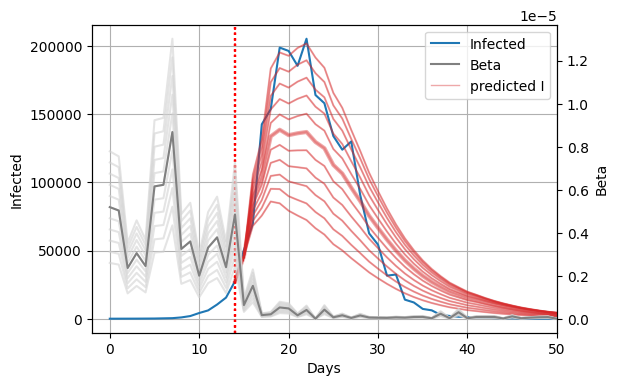

In [137]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax_b = ax.twinx()

df = pd.read_csv(one_seed)
l1 = ax.plot(df.I_H1N1, color='tab:blue', alpha=1, label='Infected')

seed_df = df.iloc[:,:5].copy()
seed_df.columns = ['S','E','I','R','Beta']
end_df  = seed_df[(seed_df.E==0)&(seed_df.I==0)]
if end_df.shape[0]:
    seed_df = seed_df.iloc[:end_df.index[0]].copy()

real_peakt = seed_df.I.argmax()
real_peakh = seed_df.I.max()


switch_day = 14

for coeff in range(-5, 6):
#switch_day = choice_start_day.cpoint_fraq_people(seed_df, fraq=0.035)
    ax.axvline(switch_day, ls=':', color='red', alpha=0.5)   
    
    #switch_day=25
    y0 = seed_df.iloc[switch_day,:4].values
    ts = np.arange(seed_df.shape[0]-switch_day)

    sigma = 1/2
    gamma = 1/6

    res_dict = dict()
    b = seed_df.Beta.values * (1 + coeff/10)
    ax_b.plot(b, color='lightgray', ls='-', alpha=0.6, label='Beta')
    S,E,I,R = seir_discrete.seir_model(y0, ts, b[switch_day:], 
                                       sigma, gamma, stype='d', 
                                       beta_t=True).T
    ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
            alpha=0.3)

    predicted_peakt = I.argmax()+switch_day
    predicted_peakh = I.max()
    pt_err = abs(real_peakt - predicted_peakt)
    ph_err = abs(real_peakh - predicted_peakh)

    if (1 + coeff/10) == 1:
        lw=3
    else:
        lw=1
        
    l3 = ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
                    alpha=0.4, label='predicted I', lw=lw)
    
l2 = ax_b.plot(seed_df.Beta, color='gray', alpha=1, label='Beta')
lns = l1+l2+l3
labs = [l.get_label() for l in lns]

leg = ax.legend(lns, labs)
 
ax.set_xlim(-2, 50)
ax.grid()    
ax.set_ylabel('Infected')
ax_b.set_ylabel('Beta')
ax.set_xlabel('Days')

#### 15

Text(0.5, 0, 'Days')

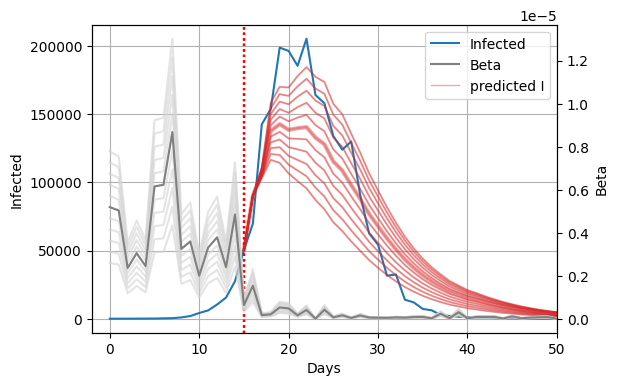

In [151]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax_b = ax.twinx()

df = pd.read_csv(one_seed)
l1 = ax.plot(df.I_H1N1, color='tab:blue', alpha=1, label='Infected')

seed_df = df.iloc[:,:5].copy()
seed_df.columns = ['S','E','I','R','Beta']
end_df  = seed_df[(seed_df.E==0)&(seed_df.I==0)]
if end_df.shape[0]:
    seed_df = seed_df.iloc[:end_df.index[0]].copy()

real_peakt = seed_df.I.argmax()
real_peakh = seed_df.I.max()


switch_day = 15

for coeff in range(-5, 6):
#switch_day = choice_start_day.cpoint_fraq_people(seed_df, fraq=0.035)
    ax.axvline(switch_day, ls=':', color='red', alpha=0.5)   
    
    #switch_day=25
    y0 = seed_df.iloc[switch_day,:4].values
    ts = np.arange(seed_df.shape[0]-switch_day)

    sigma = 1/2
    gamma = 1/6

    res_dict = dict()
    b = seed_df.Beta.values * (1 + coeff/10)
    ax_b.plot(b, color='lightgray', ls='-', alpha=0.6, label='Beta')
    S,E,I,R = seir_discrete.seir_model(y0, ts, b[switch_day:], 
                                       sigma, gamma, stype='d', 
                                       beta_t=True).T
    ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
            alpha=0.3)

    predicted_peakt = I.argmax()+switch_day
    predicted_peakh = I.max()
    pt_err = abs(real_peakt - predicted_peakt)
    ph_err = abs(real_peakh - predicted_peakh)

    if (1 + coeff/10) == 1:
        lw=3
    else:
        lw=1
        
    l3 = ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
                    alpha=0.4, label='predicted I', lw=lw)
    
l2 = ax_b.plot(seed_df.Beta, color='gray', alpha=1, label='Beta')
lns = l1+l2+l3
labs = [l.get_label() for l in lns]

leg = ax.legend(lns, labs)
 
ax.set_xlim(-2, 50)
ax.grid()    
ax.set_ylabel('Infected')
ax_b.set_ylabel('Beta')
ax.set_xlabel('Days')

#### 16

Text(0.5, 0, 'Days')

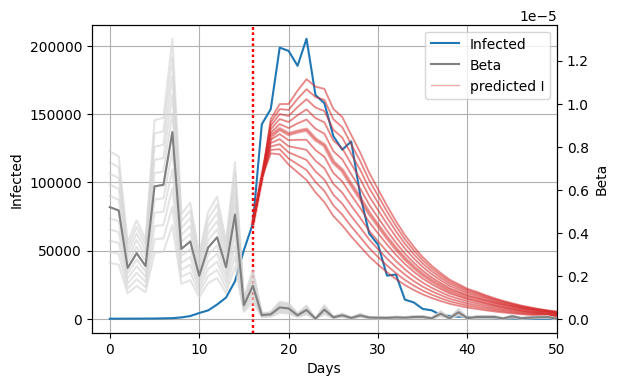

In [150]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax_b = ax.twinx()

df = pd.read_csv(one_seed)
l1 = ax.plot(df.I_H1N1, color='tab:blue', alpha=1, label='Infected')

seed_df = df.iloc[:,:5].copy()
seed_df.columns = ['S','E','I','R','Beta']
end_df  = seed_df[(seed_df.E==0)&(seed_df.I==0)]
if end_df.shape[0]:
    seed_df = seed_df.iloc[:end_df.index[0]].copy()

real_peakt = seed_df.I.argmax()
real_peakh = seed_df.I.max()


switch_day = 16

for coeff in range(-5, 6):
#switch_day = choice_start_day.cpoint_fraq_people(seed_df, fraq=0.035)
    ax.axvline(switch_day, ls=':', color='red', alpha=0.5)   
    
    #switch_day=25
    y0 = seed_df.iloc[switch_day,:4].values
    ts = np.arange(seed_df.shape[0]-switch_day)

    sigma = 1/2
    gamma = 1/6

    res_dict = dict()
    b = seed_df.Beta.values * (1 + coeff/10)
    ax_b.plot(b, color='lightgray', ls='-', alpha=0.6, label='Beta')
    S,E,I,R = seir_discrete.seir_model(y0, ts, b[switch_day:], 
                                       sigma, gamma, stype='d', 
                                       beta_t=True).T
    ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
            alpha=0.3)

    predicted_peakt = I.argmax()+switch_day
    predicted_peakh = I.max()
    pt_err = abs(real_peakt - predicted_peakt)
    ph_err = abs(real_peakh - predicted_peakh)

    if (1 + coeff/10) == 1:
        lw=3
    else:
        lw=1
        
    l3 = ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
                    alpha=0.4, label='predicted I', lw=lw)
    
l2 = ax_b.plot(seed_df.Beta, color='gray', alpha=1, label='Beta')
lns = l1+l2+l3
labs = [l.get_label() for l in lns]

leg = ax.legend(lns, labs)
 
ax.set_xlim(-2, 50)
ax.grid()    
ax.set_ylabel('Infected')
ax_b.set_ylabel('Beta')
ax.set_xlabel('Days')

#### 17

Text(0.5, 0, 'Days')

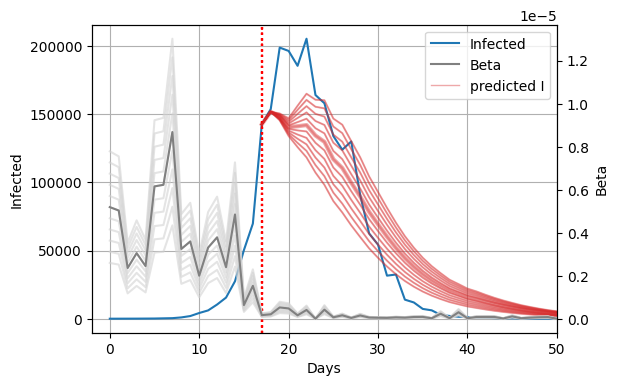

In [147]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax_b = ax.twinx()

df = pd.read_csv(one_seed)
l1 = ax.plot(df.I_H1N1, color='tab:blue', alpha=1, label='Infected')

seed_df = df.iloc[:,:5].copy()
seed_df.columns = ['S','E','I','R','Beta']
end_df  = seed_df[(seed_df.E==0)&(seed_df.I==0)]
if end_df.shape[0]:
    seed_df = seed_df.iloc[:end_df.index[0]].copy()

real_peakt = seed_df.I.argmax()
real_peakh = seed_df.I.max()


switch_day = 17

for coeff in range(-5, 6):
#switch_day = choice_start_day.cpoint_fraq_people(seed_df, fraq=0.035)
    ax.axvline(switch_day, ls=':', color='red', alpha=0.5)   
    
    #switch_day=25
    y0 = seed_df.iloc[switch_day,:4].values
    ts = np.arange(seed_df.shape[0]-switch_day)

    sigma = 1/2
    gamma = 1/6

    res_dict = dict()
    b = seed_df.Beta.values * (1 + coeff/10)
    ax_b.plot(b, color='lightgray', ls='-', alpha=0.6, label='Beta')
    S,E,I,R = seir_discrete.seir_model(y0, ts, b[switch_day:], 
                                       sigma, gamma, stype='d', 
                                       beta_t=True).T
    ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
            alpha=0.3)

    predicted_peakt = I.argmax()+switch_day
    predicted_peakh = I.max()
    pt_err = abs(real_peakt - predicted_peakt)
    ph_err = abs(real_peakh - predicted_peakh)
    if (1 + coeff/10) == 1:
        lw=3
    else:
        lw=1
        
    l3 = ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
                    alpha=0.4, label='predicted I', lw=lw)
    
l2 = ax_b.plot(seed_df.Beta, color='gray', alpha=1, label='Beta')
lns = l1+l2+l3
labs = [l.get_label() for l in lns]

leg = ax.legend(lns, labs)
 
ax.set_xlim(-2, 50)
ax.grid()    
ax.set_ylabel('Infected')
ax_b.set_ylabel('Beta')
ax.set_xlabel('Days')

### diff. beta (coeff 1.5--3), one day

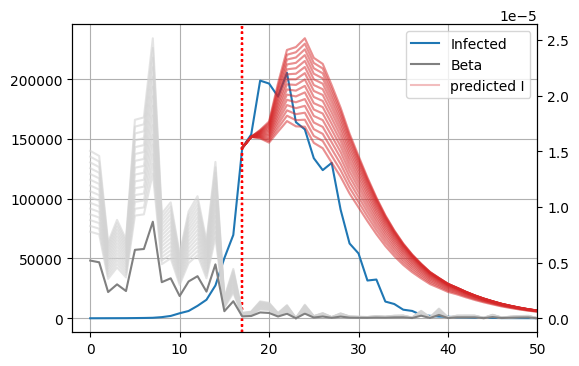

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax_b = ax.twinx()

df = pd.read_csv(one_seed)
l1 = ax.plot(df.I_H1N1, color='tab:blue', alpha=1, label='Infected')

seed_df = df.iloc[:,:5].copy()
seed_df.columns = ['S','E','I','R','Beta']
end_df  = seed_df[(seed_df.E==0)&(seed_df.I==0)]
if end_df.shape[0]:
    seed_df = seed_df.iloc[:end_df.index[0]].copy()

real_peakt = seed_df.I.argmax()
real_peakh = seed_df.I.max()


switch_day = 17

for coeff in range(5, 20):
#switch_day = choice_start_day.cpoint_fraq_people(seed_df, fraq=0.035)
    ax.axvline(switch_day, ls=':', color='red', alpha=0.5)   
    
    #switch_day=25
    y0 = seed_df.iloc[switch_day,:4].values
    ts = np.arange(seed_df.shape[0]-switch_day)

    sigma = 1/2
    gamma = 1/6

    res_dict = dict()
    b = seed_df.Beta.values * (1 + coeff/10)
    ax_b.plot(b, color='lightgray', ls='-', alpha=0.6, label='Beta')
    S,E,I,R = seir_discrete.seir_model(y0, ts, b[switch_day:], 
                                       sigma, gamma, stype='d', 
                                       beta_t=True).T
    ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
            alpha=0.3)

    predicted_peakt = I.argmax()+switch_day
    predicted_peakh = I.max()
    pt_err = abs(real_peakt - predicted_peakt)
    ph_err = abs(real_peakh - predicted_peakh)

    l3 = ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
                    alpha=0.3, label='predicted I')
    
l2 = ax_b.plot(seed_df.Beta, color='gray', alpha=1, label='Beta')
lns = l1+l2+l3
labs = [l.get_label() for l in lns]

leg = ax.legend(lns, labs)

 
ax.set_xlim(-2, 50)
ax.grid()    

### diff. beta (coeff 0.5--1.5), diff. days

In [118]:
import matplotlib as mpl

cmap = mpl.colormaps['viridis']
colors_l = cmap(np.linspace(0, 1, 8))

colors = list(colors_l)

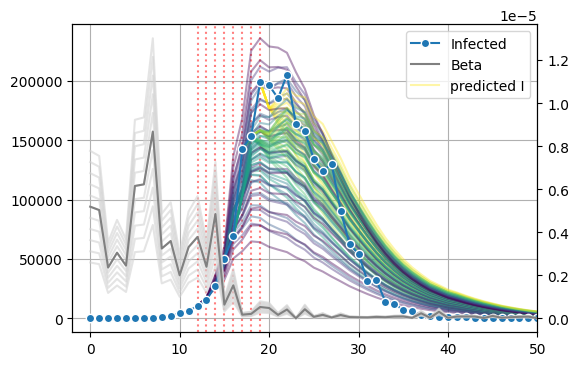

In [152]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax_b = ax.twinx()

df = pd.read_csv(one_seed)


seed_df = df.iloc[:,:5].copy()
seed_df.columns = ['S','E','I','R','Beta']
end_df  = seed_df[(seed_df.E==0)&(seed_df.I==0)]
if end_df.shape[0]:
    seed_df = seed_df.iloc[:end_df.index[0]].copy()

real_peakt = seed_df.I.argmax()
real_peakh = seed_df.I.max()


switch_day = 18

for i, coeff in enumerate(range(-5, 6)):
    
    for j, switch_day in enumerate(range(12,20)):
#switch_day = choice_start_day.cpoint_fraq_people(seed_df, fraq=0.035)
        if i==0:
            ax.axvline(switch_day, ls=':', color='red', alpha=0.5)   

        #switch_day=25
        y0 = seed_df.iloc[switch_day,:4].values
        ts = np.arange(seed_df.shape[0]-switch_day)

        sigma = 1/2
        gamma = 1/6

        res_dict = dict()
        b = seed_df.Beta.values * (1 + coeff/10)
        if j==0:
            ax_b.plot(b, color='lightgray', ls='-', alpha=0.6, label='Beta')
        
        S,E,I,R = seir_discrete.seir_model(y0, ts, b[switch_day:], 
                                           sigma, gamma, stype='d', 
                                           beta_t=True).T
        
        predicted_peakt = I.argmax()+switch_day
        predicted_peakh = I.max()
        pt_err = abs(real_peakt - predicted_peakt)
        ph_err = abs(real_peakh - predicted_peakh)

        lw=1.5

        l3 = ax.plot(ts+switch_day, I, color=colors[j], ls='-', 
                        alpha=0.4, label='predicted I', lw=lw)
        
l1 = ax.plot(df.I_H1N1, color='tab:blue', alpha=1, label='Infected',
            marker='o', ls='-', markeredgecolor='white')    
l2 = ax_b.plot(seed_df.Beta, color='gray', alpha=1, label='Beta')
lns = l1+l2+l3
labs = [l.get_label() for l in lns]

leg = ax.legend(lns, labs)

 
ax.set_xlim(-2, 50)
ax.grid()    

### diff. beta (coeff 1.5--3), diff. days

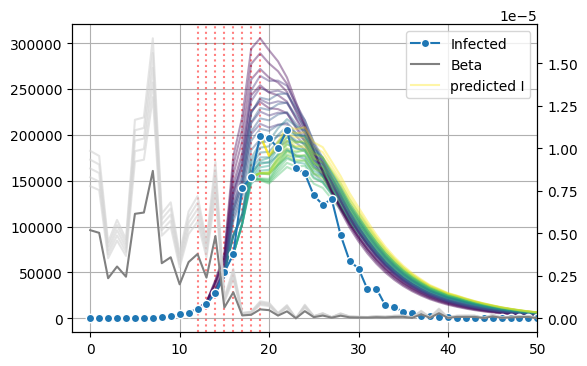

In [133]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax_b = ax.twinx()

df = pd.read_csv(one_seed)


seed_df = df.iloc[:,:5].copy()
seed_df.columns = ['S','E','I','R','Beta']
end_df  = seed_df[(seed_df.E==0)&(seed_df.I==0)]
if end_df.shape[0]:
    seed_df = seed_df.iloc[:end_df.index[0]].copy()

real_peakt = seed_df.I.argmax()
real_peakh = seed_df.I.max()


switch_day = 18

for i, coeff in enumerate(range(5, 10)):
    
    for j, switch_day in enumerate(range(12,20)):
#switch_day = choice_start_day.cpoint_fraq_people(seed_df, fraq=0.035)
        if i==0:
            ax.axvline(switch_day, ls=':', color='red', alpha=0.5)   

        #switch_day=25
        y0 = seed_df.iloc[switch_day,:4].values
        ts = np.arange(seed_df.shape[0]-switch_day)

        sigma = 1/2
        gamma = 1/6

        res_dict = dict()
        b = seed_df.Beta.values * (1 + coeff/10)
        if j==0:
            ax_b.plot(b, color='lightgray', ls='-', alpha=0.6, label='Beta')
        
        S,E,I,R = seir_discrete.seir_model(y0, ts, b[switch_day:], 
                                           sigma, gamma, stype='d', 
                                           beta_t=True).T
        
        predicted_peakt = I.argmax()+switch_day
        predicted_peakh = I.max()
        pt_err = abs(real_peakt - predicted_peakt)
        ph_err = abs(real_peakh - predicted_peakh)

        lw=1.5

        l3 = ax.plot(ts+switch_day, I, color=colors[j], ls='-', 
                        alpha=0.4, label='predicted I', lw=lw)
    
l2 = ax_b.plot(seed_df.Beta, color='gray', alpha=1, label='Beta')

l1 = ax.plot(df.I_H1N1, color='tab:blue', alpha=1, label='Infected',
            marker='o', ls='-', markeredgecolor='white')

lns = l1+l2+l3
labs = [l.get_label() for l in lns]

leg = ax.legend(lns, labs)

 
ax.set_xlim(-2, 50)
ax.grid()    

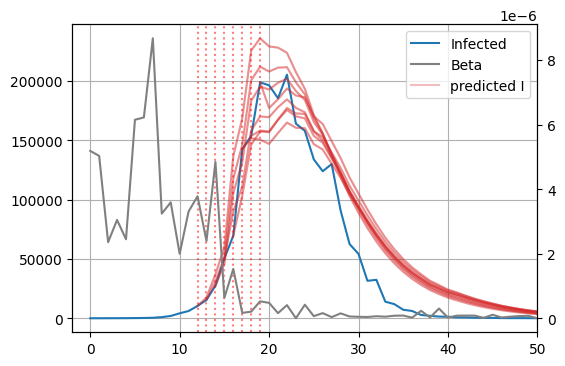

In [79]:
# если увеличить значение реальной беты в 1.5раз

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax_b = ax.twinx()

df = pd.read_csv(one_seed)
l1 = ax.plot(df.I_H1N1, color='tab:blue', alpha=1, label='Infected')

seed_df = df.iloc[:,:5].copy()
seed_df.columns = ['S','E','I','R','Beta']
end_df  = seed_df[(seed_df.E==0)&(seed_df.I==0)]
if end_df.shape[0]:
    seed_df = seed_df.iloc[:end_df.index[0]].copy()

real_peakt = seed_df.I.argmax()
real_peakh = seed_df.I.max()
l2 = ax_b.plot(seed_df.Beta, color='gray', alpha=1, label='Beta')

for switch_day in range(12, 20):
#switch_day = choice_start_day.cpoint_fraq_people(seed_df, fraq=0.035)
    ax.axvline(switch_day, ls=':', color='red', alpha=0.5)   
    
    #switch_day=25
    y0 = seed_df.iloc[switch_day,:4].values
    ts = np.arange(seed_df.shape[0]-switch_day)

    sigma = 1/2
    gamma = 1/6

    res_dict = dict()

    b = seed_df.Beta[switch_day:].values * 1.5
    S,E,I,R = seir_discrete.seir_model(y0, ts, b, 
                                       sigma, gamma, stype='d', 
                                       beta_t=True).T
    ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
            alpha=0.3)

    predicted_peakt = I.argmax()+switch_day
    predicted_peakh = I.max()
    pt_err = abs(real_peakt - predicted_peakt)
    ph_err = abs(real_peakh - predicted_peakh)

    l3 = ax.plot(ts+switch_day, I, color='tab:red', ls='-', 
                    alpha=0.3, label='predicted I')

lns = l1+l2+l3
labs = [l.get_label() for l in lns]

leg = ax.legend(lns, labs)

 
ax.set_xlim(-2, 50)
ax.grid()    

In [183]:
from sklearn.metrics import root_mean_squared_error as rmse

In [187]:
df_b[df_b.S_H1N1==0].index[0]

np.int64(52)

In [198]:

plot = True
df_b = pd.read_csv(one_seed)
fin = df_b[df_b.S_H1N1==0].index[0]
real_peakt = df_b.I_H1N1.argmax()
real_peakh = df_b.I_H1N1.max()

#st_day = choice_start_day.choose_method(df_b, start_day)
st_day = real_peakt - 7
betas = df_b.beta_H1N1

y0 = df_b.iloc[st_day,:4].values
ts = np.arange(fin-st_day)

col = 'tab:red'
lab = 'SEIR I (exp.mean beta)'

res_dict = dict()

for coeff in range(-5,6):
    b = betas[st_day:].values * (1 + coeff/10)
    #ax_beta.plot(b, ls='--', color='tab:green')
    r = seir_discrete.seir_model(y0, ts, b, 
                                       sigma, gamma, stype='d', 
                                       beta_t=True).T
    S,E,I,R = r
    if plot:
        ax.plot(ts+st_day, I, color=col, ls='-', alpha=0.3)
    predicted_peakt = I.argmax()+st_day
    predicted_peakh = I.max()

    rmse_pt = rmse([real_peakt], [predicted_peakt])
    rmse_ph = rmse([real_peakh], [predicted_peakh])
    res_dict[(1 + coeff/10)] = [rmse_pt,rmse_ph]

best_b = pd.DataFrame.from_dict(res_dict).T.reset_index()
best_b.columns = ['beta', 'rmse_pt', 'rmse_ph']


In [199]:
best_b

beta  rmse_pt       rmse_ph
0    0.5      2.0  21911.649980
1    0.6      2.0  19977.642748
2    0.7      1.0  17863.528594
3    0.8      1.0  15568.085158
4    0.9      1.0  13205.294243
5    1.0      1.0  10778.322258
6    1.1      1.0   8290.395213
7    1.2      1.0   5744.793869
8    1.3      1.0   3144.848806
9    1.4      1.0    493.935427
10   1.5      1.0   2204.531096

In [192]:
rmse_pt, predicted_peakh

(2.0, np.float64(15165.350020065474))

### boxes

#### real, 4 days

(1, 1303)


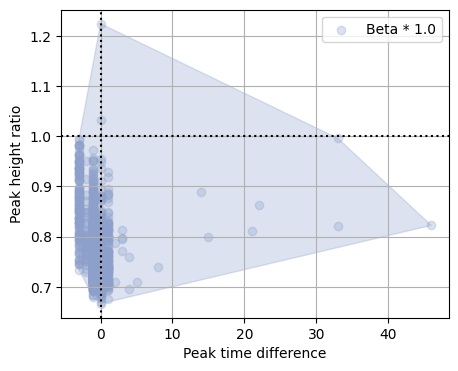

In [7]:
switch.beta_and_coeffs(start_day=3, sigma=1/2, gamma=1/6,
                      files = X_train_all['file'].values.flatten(), 
                       plot=False, coeffs=[0])

(1, 1303)


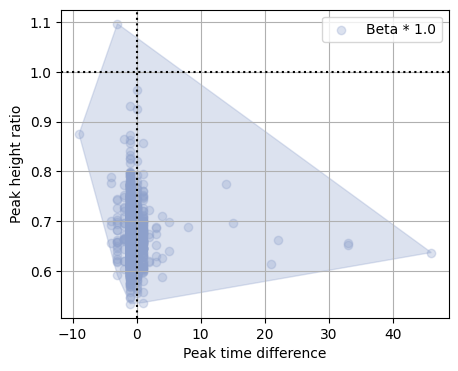

In [52]:
switch.beta_and_coeffs(start_day=10, sigma=1/2, gamma=1/6,
                      files = X_train_all['file'].values.flatten(), 
                       plot=False, coeffs=[0])

(1, 1303)


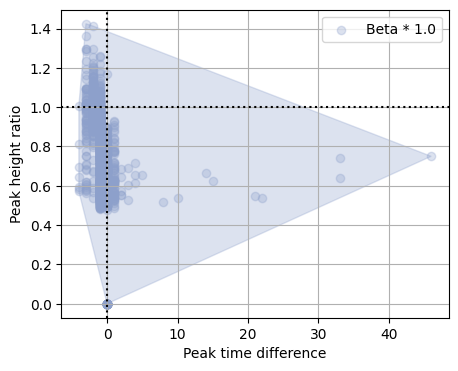

In [53]:
switch.beta_and_coeffs(start_day=15, sigma=1/2, gamma=1/6,
                      files = X_train_all['file'].values.flatten(), 
                       plot=False, coeffs=[0])

(1, 1303)


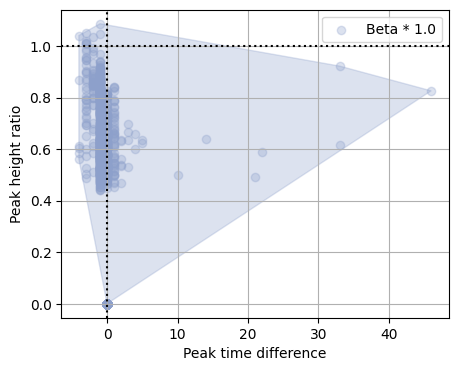

In [55]:
switch.beta_and_coeffs(start_day=18, sigma=1/2, gamma=1/6,
                      files = X_train_all['file'].values.flatten(), 
                       plot=False, coeffs=[0])

#### coeffs -2,0,2

(3, 1303)


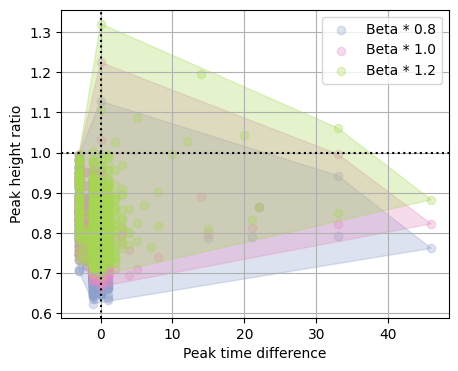

In [45]:
switch.beta_and_coeffs(start_day=3, sigma=1/2, gamma=1/6,
                      files = X_train_all['file'].values.flatten(), 
                       plot=False, coeffs=[-2,0,2])

(3, 1303)


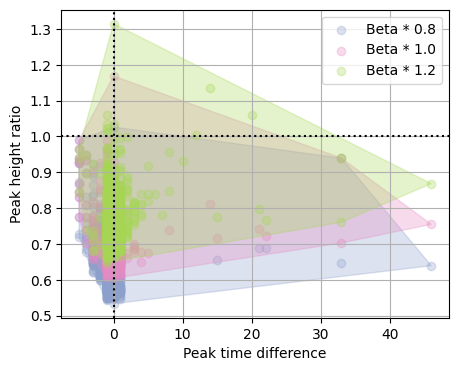

In [46]:
switch.beta_and_coeffs(start_day=5, sigma=1/2, gamma=1/6,
                      files = X_train_all['file'].values.flatten(), 
                       plot=False, coeffs=[-2,0,2])

(3, 1303)


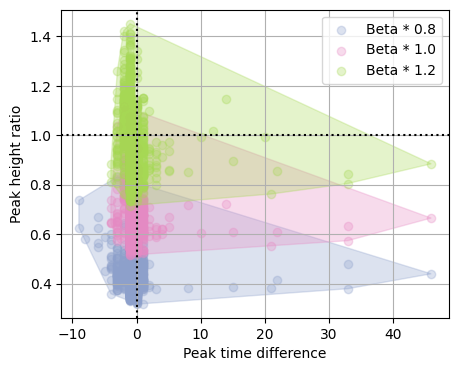

In [47]:
switch.beta_and_coeffs(start_day=12, sigma=1/2, gamma=1/6,
                      files = X_train_all['file'].values.flatten(), 
                       plot=False, coeffs=[-2,0,2])

(3, 1303)


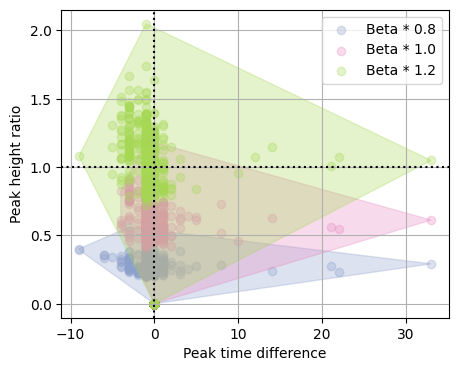

In [49]:
switch.beta_and_coeffs(start_day=20, sigma=1/2, gamma=1/6,
                      files = X_train_all['file'].values.flatten(), 
                       plot=False, coeffs=[-2,0,2])

#### coeffs -4,-2,0,2,4

(5, 1303)


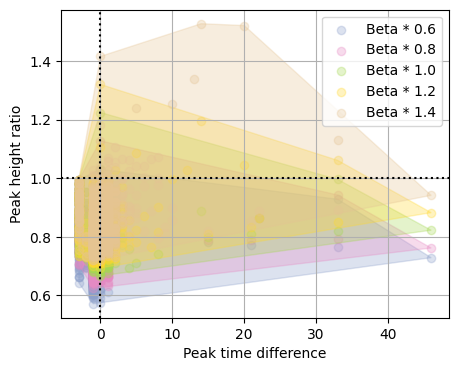

In [8]:
switch.beta_and_coeffs(start_day=3, sigma=1/2, gamma=1/6,
                      files = X_train_all['file'].values.flatten(), 
                       plot=False, coeffs=[-4,-2,0,2,4])

(5, 1303)


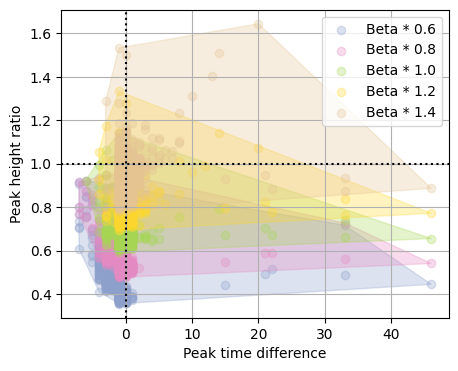

In [9]:
switch.beta_and_coeffs(start_day=7, sigma=1/2, gamma=1/6,
                      files = X_train_all['file'].values.flatten(), 
                       plot=False, coeffs=[-4,-2,0,2,4])

(5, 1303)


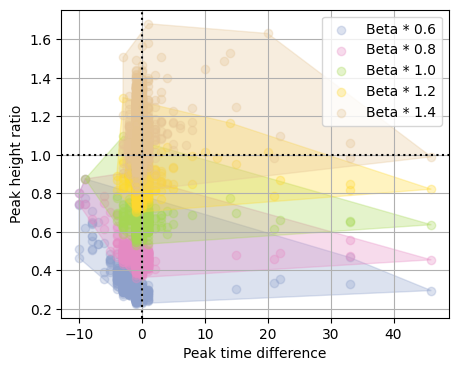

In [10]:
switch.beta_and_coeffs(start_day=10, sigma=1/2, gamma=1/6,
                      files = X_train_all['file'].values.flatten(), 
                       plot=False, coeffs=[-4,-2,0,2,4])

(5, 1303)


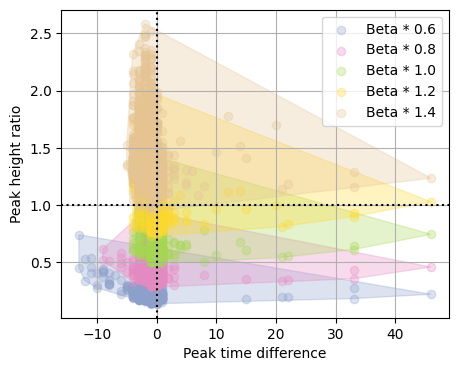

In [11]:
switch.beta_and_coeffs(start_day=14, sigma=1/2, gamma=1/6,
                      files = X_train_all['file'].values.flatten(), 
                       plot=False, coeffs=[-4,-2,0,2,4])

(5, 1303)


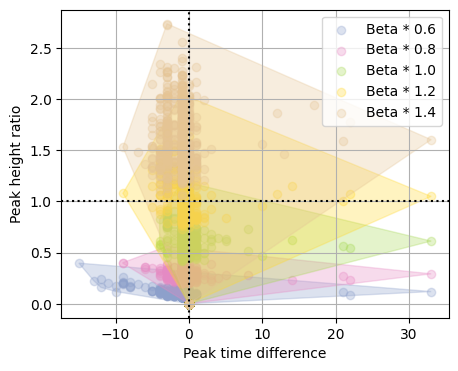

In [12]:
switch.beta_and_coeffs(start_day=20, sigma=1/2, gamma=1/6,
                      files = X_train_all['file'].values.flatten(), 
                       plot=False, coeffs=[-4,-2,0,2,4])

(5, 1303)


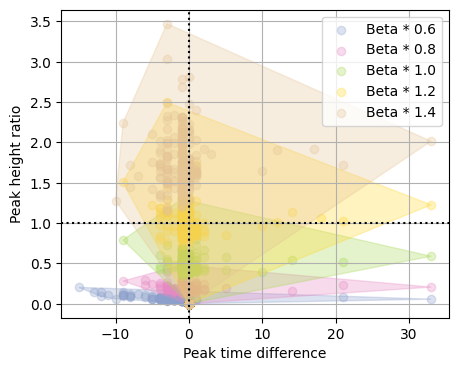

In [13]:
switch.beta_and_coeffs(start_day=25, sigma=1/2, gamma=1/6,
                      files = X_train_all['file'].values.flatten(), 
                       plot=False, coeffs=[-4,-2,0,2,4])

(2, 1303)


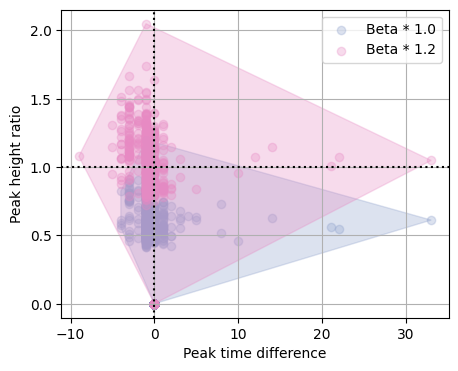

In [90]:
switch.beta_and_coeffs(start_day=20, sigma=1/2, gamma=1/6,
                      files = X_train_all['file'].values.flatten(), 
                       plot=False, coeffs=[0,2])

(5, 4)


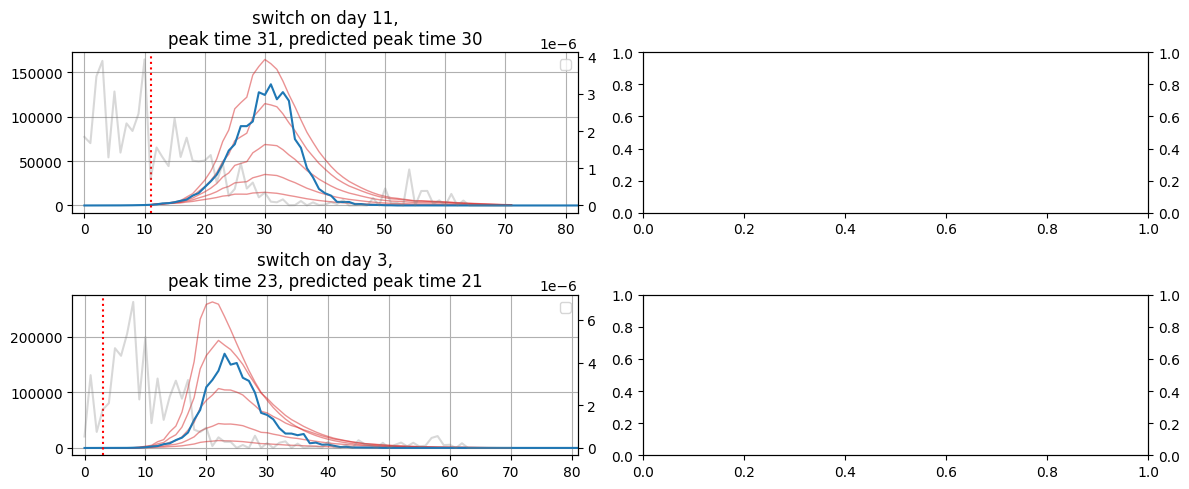

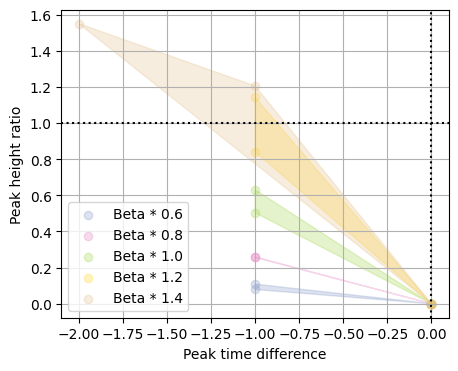

In [59]:
switch.beta_and_coeffs(start_day=20, sigma=1/2, gamma=1/6,
                      files = X_train_all['file'].values.flatten()[:4], 
                       plot=True, coeffs=[-4,-2,0,2,4])

#### days (20,15,10,5)

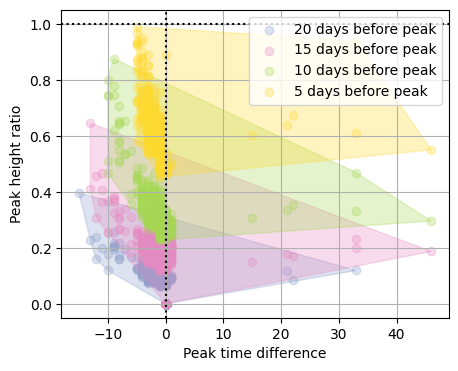

In [14]:
switch.beta_and_coeffs_days(start_days=[20,15,10,5], sigma=1/2, gamma=1/6,
                              files = X_train_all['file'].values.flatten(),
                            plot=False, coeff = -4)

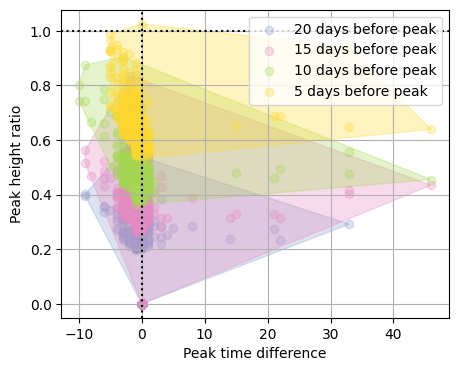

In [15]:
switch.beta_and_coeffs_days(start_days=[20,15,10,5], sigma=1/2, gamma=1/6,
                              files = X_train_all['file'].values.flatten(),
                            plot=False, coeff = -2)

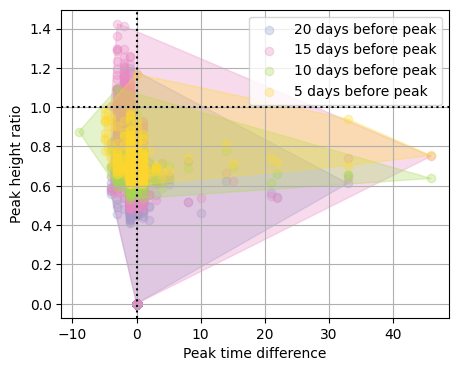

In [16]:
switch.beta_and_coeffs_days(start_days=[20,15,10,5], sigma=1/2, gamma=1/6,
                              files = X_train_all['file'].values.flatten(),
                            plot=False, coeff = 0)

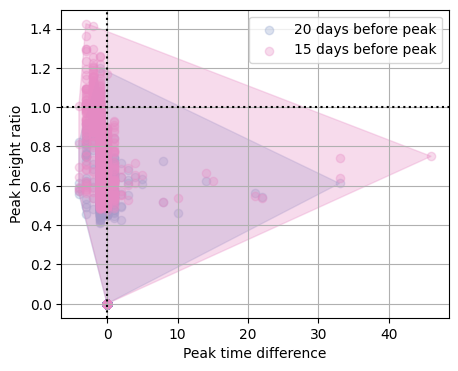

In [79]:
switch.beta_and_coeffs_days(start_days=[20,15], sigma=1/2, gamma=1/6,
                              files = X_train_all['file'].values.flatten(),
                            plot=False, coeff = 0)

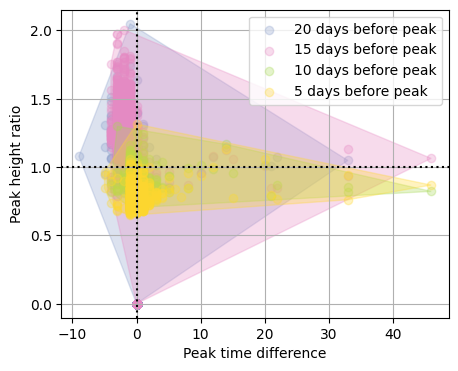

In [17]:
switch.beta_and_coeffs_days(start_days=[20,15,10,5], sigma=1/2, gamma=1/6,
                              files = X_train_all['file'].values.flatten(),
                            plot=False, coeff = 2)

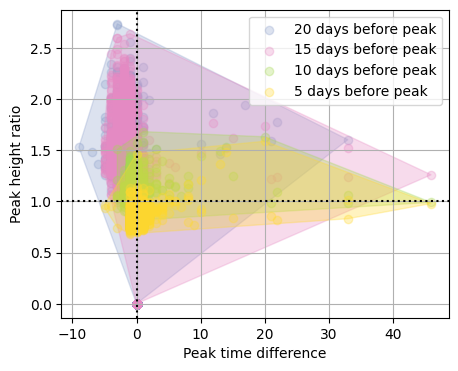

In [18]:
switch.beta_and_coeffs_days(start_days=[20,15,10,5], sigma=1/2, gamma=1/6,
                              files = X_train_all['file'].values.flatten(),
                            plot=False, coeff = 4)

In [237]:
df_b = pd.read_csv(X_train_all['file'].values.flatten()[80])
df_b

S_H1N1  E_H1N1  I_H1N1    R_H1N1     beta_H1N1
0    318117.0     7.0    10.0  477202.0 -0.000000e+00
1    318117.0     7.0    10.0  477202.0  1.571749e-06
2    318112.0     5.0    17.0  477202.0  3.698291e-07
3    318110.0     7.0    17.0  477202.0 -0.000000e+00
4    318110.0     2.0    22.0  477202.0  1.428894e-07
..        ...     ...     ...       ...           ...
245       0.0     0.0     0.0       0.0           NaN
246       0.0     0.0     0.0       0.0           NaN
247       0.0     0.0     0.0       0.0           NaN
248       0.0     0.0     0.0       0.0           NaN
249       0.0     0.0     0.0       0.0           NaN

[250 rows x 5 columns]

<Axes: >

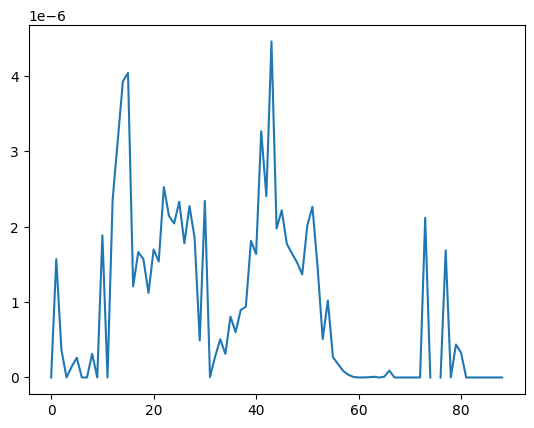

In [240]:
df_b.iloc[:89].beta_H1N1.plot()

<Axes: >

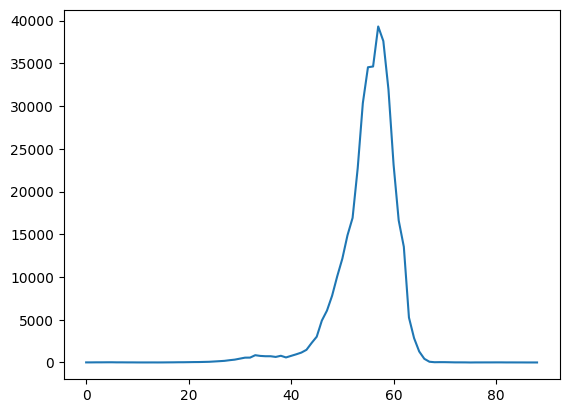

In [241]:
df_b.iloc[:89].I_H1N1.plot()

In [238]:
fin = df_b[df_b.S_H1N1==0].index[0]
fin

np.int64(89)

## stuff

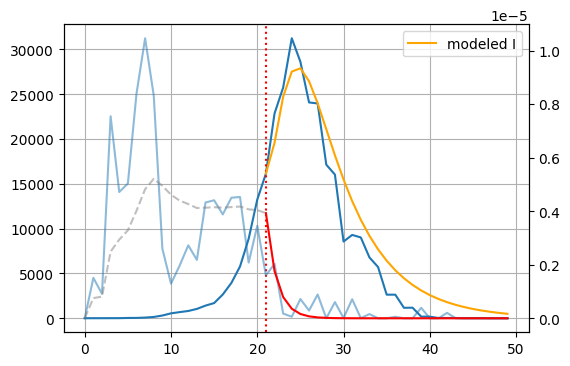

In [250]:
# from b0 to phi*b0 at rate q. phi ~ 1/r_0
def func(t, b0, phi, q):
    return b0*( (1-phi)*np.exp(-q*t) + phi)

switch_day = seed_df.I.argmax()-3

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax_b = ax.twinx()

ax.plot(seed_df.I)
ax_b.plot(seed_df.Beta, alpha=0.5)
beta_e = seed_df.Beta.expanding().mean()[:switch_day+1]
ax_b.plot(beta_e, alpha=0.5, ls='--', color='gray')

days = np.arange(switch_day, seed_df.shape[0])
b0 = beta_e.iloc[-1]
phi = (1/2)*b0
q = 0.8

ax.axvline(switch_day, ls=':', color='red')


y0 = df.iloc[switch_day,:4].values
bb = func(days-switch_day , b0, phi, q)

ax_b.plot(days, bb, color='red')

S,E,I,R = seir_discrete.seir_model(y0, days-switch_day, bb,
                                   sigma, gamma, stype='d', 
                                   beta_t=True).T
ax.plot(days, I, color='orange', ls='-', 
        alpha=1, label='modeled I')

ax.grid()
ax.legend()

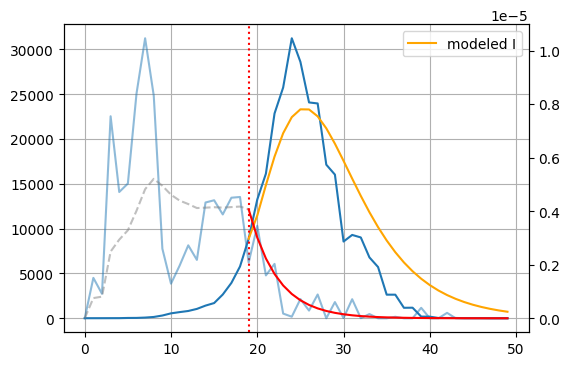

In [246]:
# from b0 to phi*b0 at rate q. phi ~ 1/r_0
def func(t, b0, phi, q):
    return b0*( (1-phi)*np.exp(-q*t) + phi)

switch_day = seed_df.I.argmax()-5

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax_b = ax.twinx()

ax.plot(seed_df.I)
ax_b.plot(seed_df.Beta, alpha=0.5)
beta_e = seed_df.Beta.expanding().mean()[:switch_day+1]
ax_b.plot(beta_e, alpha=0.5, ls='--', color='gray')

days = np.arange(switch_day, seed_df.shape[0])
b0 = beta_e.iloc[-1]
phi = (1/2)*b0
q = 0.3

ax.axvline(switch_day, ls=':', color='red')


y0 = df.iloc[switch_day,:4].values
bb = func(days-switch_day , b0, phi, q)

ax_b.plot(days, bb, color='red')

S,E,I,R = seir_discrete.seir_model(y0, days-switch_day, bb,
                                   sigma, gamma, stype='d', 
                                   beta_t=True).T
ax.plot(days, I, color='orange', ls='-', 
        alpha=1, label='modeled I')

ax.grid()
ax.legend()